Simply debias BERT by optimizing the log odds ratio

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
import matplotlib.pyplot as plt
from overrides import overrides
%matplotlib inline

In [3]:
import sys
sys.path.append("../lib")

In [4]:
lr = 5e-5
weight_reg = 1e-4
train_file = "gender_occ_pos_w_probs_train.txt"
val_file = "gender_occ_pos_w_probs_val.txt"

In [5]:
# Parameters
lr = 1e-05
train_file = "gender_occ_pos_w_probs_train.txt"
val_file = "gender_occ_pos_w_probs_val.txt"


In [6]:
from bert_utils import Config, BertPreprocessor
config = Config(
    model_type="bert-base-uncased",
    max_seq_len=24,
    batch_size=32,
    bias_weight=1., # technically unnecessary, but for easier debugging
    consistency_weight=1.,
    lr=lr,
    weight_reg=weight_reg,
    disable_dropout=True,
    init_probs_precomputed=True,
    testing=True,
    remove_prior_bias=True,
    epochs=3,
    train_file=train_file,
    val_file=val_file,
)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
T = TypeVar("T")
TensorDict = Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]

In [9]:
processor = BertPreprocessor(config.model_type, config.max_seq_len)

In [10]:
DATA_ROOT = Path("../data")
MODEL_SAVE_DIR = Path("../weights")

Read the model in here

In [11]:
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
masked_lm = BertForMaskedLM.from_pretrained(config.model_type)
masked_lm.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
       

Dropout might be causing the model to be more uncertain, attributing lower probs to the correct sentence: disabling might help with logit explosion

In [12]:
if config.disable_dropout:
    def disable_dropout(mod):
        if hasattr(mod, "named_children"):
            for nm, child in mod.named_children():
                if "dropout" in nm: child.p = 0. # forcibly set to 0
                disable_dropout(child)
    disable_dropout(masked_lm)

In [13]:
masked_lm

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.0)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.0)
            )
          )
          (intermediate): BertIntermediate(
       

Freeze positional embeddings

In [14]:
masked_lm.bert.embeddings.position_embeddings.requires_grad = False
masked_lm.bert.embeddings.token_type_embeddings.requires_grad = False

Freeze layer norm

In [15]:
for k, v in masked_lm.named_parameters():
    if "LayerNorm" in k: v.requires_grad = False

# The Dataset

In [16]:
from allennlp.data.token_indexers import PretrainedBertIndexer

def flatten(x: List[List[T]]) -> List[T]:
        return [item for sublist in x for item in sublist]

token_indexer = PretrainedBertIndexer(
    pretrained_model=config.model_type,
    max_pieces=config.max_seq_len,
    do_lowercase=True,
 )

def tokenizer(s: str):
    maxlen = config.max_seq_len - 2
    toks = token_indexer.wordpiece_tokenizer(s)[:maxlen]
    return toks

In [17]:
def to_np(t): return t.detach().cpu().numpy()

def to_words(arr):
    if len(arr.shape) > 1:
        return [to_words(a) for a in arr]
    else:
        arr = to_np(arr)
        return " ".join([itot(i) for i in arr])

In [18]:
rev_vocab = {v: k for k, v in token_indexer.vocab.items()}

def ttoi(t: str): return token_indexer.vocab[t]
def itot(i: int): return rev_vocab[i]

In [19]:
from allennlp.data.vocabulary import Vocabulary
global_vocab = Vocabulary()

### Dataset

In [20]:
import csv
from allennlp.data import DatasetReader, Instance, Token
from allennlp.data.fields import (TextField, SequenceLabelField, LabelField, 
                                  MetadataField, ArrayField)

class BertTextField(TextField):
    @overrides
    def get_padding_lengths(self): # consistent padding lengths
        pad_lengths = super().get_padding_lengths()
        for k in pad_lengths.keys():
            pad_lengths[k] = config.max_seq_len
        return pad_lengths

class LongArrayField(ArrayField):
    @overrides
    def as_tensor(self, padding_lengths: Dict[str, int]) -> torch.Tensor:
        tensor = torch.from_numpy(self.array)
        return tensor
    
class FloatArrayField(ArrayField):
    @overrides
    def as_tensor(self, padding_lengths: Dict[str, int]) -> torch.FloatTensor:
        tensor = torch.FloatTensor(self.array)
        return tensor

class DebiasingDatasetReader(DatasetReader):
    def __init__(self, tokenizer, token_indexers, 
                 init_probs_precomputed: bool=False,
                 remove_prior_bias: bool=False,
                 ) -> None:
        super().__init__(lazy=False)
        self.tokenizer = tokenizer
        self.token_indexers = token_indexers
        self.vocab = token_indexers["tokens"].vocab
        self._init_probs_precomputed = init_probs_precomputed
        self._remove_prior_bias = remove_prior_bias

    def _proc(self, x):
        if x == "[MASK]" or x == "[PAD]": return x
        else: return x.lower()
        
    @overrides
    def text_to_instance(self, tokens: List[str], w1: str, w2: str, 
                         p1: Optional[float], p2: Optional[float],
                         desired_bias: Optional[float],
                        ) -> Instance:
        fields = {}
        input_toks = [Token(self._proc(x)) for x in tokens]
        fields["input"] = BertTextField(input_toks, self.token_indexers)        
        # take [CLS] token into account
        mask_position = tokens.index("[MASK]") + 1
        fields["mask_positions"] = LongArrayField(
            np.array(mask_position, dtype=np.int64),
         )
        fields["target_ids"] = LongArrayField(np.array([
            self.vocab[w1], self.vocab[w2],
        ], dtype=np.int64))
                
        if self._init_probs_precomputed:
            fields["initial_prob_sum"] = FloatArrayField(np.array(p1 + p2, dtype=np.float32))
        else:
            with torch.no_grad():
                bert_input = (self.token_indexers["tokens"]
                              .tokens_to_indices(input_toks, global_vocab, "tokens"))
                token_ids = torch.LongTensor(bert_input["tokens"]).unsqueeze(0)
                probs = masked_lm(token_ids)[0, mask_position, :].detach().numpy()
                probs = (probs - probs.max())
                probs = probs.exp() / probs.exp().sum()
                fields["initial_prob_sum"] = \
                    FloatArrayField(np.array(probs[self.vocab[w1]] + probs[self.vocab[w2]],
                               dtype=np.float32))
            
        if self._remove_prior_bias:
            fields["desired_bias"] = \
                FloatArrayField(np.array(desired_bias, dtype=np.float32))
        
        return Instance(fields)
    
    @overrides
    def _read(self, file_path: str) -> Iterator[Instance]:
        p1, p2 = 0., 0.
        with open(file_path, "rt") as f:
            reader = csv.reader(f)
            next(reader) # skip header
            for row in reader:
                if self._init_probs_precomputed: 
                    sentence, w1, w2, tgt, p1, p2, prior_bias, bias_score = row
                else: sentence, w1, w2, tgt = row
                yield self.text_to_instance(
                    self.tokenizer(sentence), 
                    w1, w2, # words
                    float(p1), float(p2), # initial probs
                    float(prior_bias), # prior bias
                )

In [21]:
reader = DebiasingDatasetReader(tokenizer=tokenizer, 
                                token_indexers={"tokens": token_indexer},
                                init_probs_precomputed=config.init_probs_precomputed,
                                remove_prior_bias=config.remove_prior_bias)
train_ds, val_ds = (reader.read(DATA_ROOT / fname) for fname in [config.train_file, config.val_file])

0it [00:00, ?it/s]

1695it [00:00, 16936.81it/s]

2484it [00:00, 16364.62it/s]


0it [00:00, ?it/s]

115it [00:00, 910.08it/s]

276it [00:00, 1990.54it/s]

In [22]:
vars(train_ds[0].fields["input"])

{'tokens': [[MASK], is, accessible],
 '_token_indexers': {'tokens': <allennlp.data.token_indexers.wordpiece_indexer.PretrainedBertIndexer at 0x1a3a0d2eb8>},
 '_indexed_tokens': None,
 '_indexer_name_to_indexed_token': None}

### Data Iterator

In [23]:
from allennlp.data.iterators import BasicIterator

iterator = BasicIterator(
        batch_size=config.batch_size, 
    )
iterator.index_with(global_vocab)

Sanity check

In [24]:
batch = next(iter(iterator(train_ds)))

In [25]:
batch

{'input': {'tokens': tensor([[  101,   103,  2003, 29321,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003, 28575,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003, 29118,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003, 14314,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003, 26103,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

# Model and Loss

### The loss function

In [26]:
def mse_loss(x, y, desired=0): return ((x - y - desired) ** 2).mean()
def mae_loss(x, y, desired=0): return (x - y - desired).abs().mean()
class HingeLoss(nn.Module):
    def __init__(self, margin: float=0.1):
        super().__init__()
        self.margin = margin
    def forward(self, x, y, desired=0.):
        return torch.relu((x - y - desired).abs().mean() - self.margin)

In [27]:
def neg_likelihood(ll, # (batch, )
               initial_prob_sum, # (batch, )
     ):
    """log likelihood of either of the target ids being chosen"""
    return -ll.mean()

class LogitConsistency(nn.Module):
    def __init__(self, distance: Callable):
        super().__init__()
        self._distance = distance
    
    def forward(self, ll, # (batch, )
                initial_prob_sum, # (batch, )
               ):
        """
        Constrains prob sum put on two words to be roughly equal
        TODO: Provide some probabilistic/statistical interpretation
        """
        d = self._distance(ll, initial_prob_sum.log())
        return d

In [28]:
from allennlp.training.metrics import Metric
class TotalProbDiff(Metric):
    def __init__(self):
        super().__init__()
        self._total = 0
        self._n_obs = 0
        
    def __call__(self, ll, initial_prob_sum):
        self._total += (ll.exp() - initial_prob_sum).mean().item()
        self._n_obs += 1
        
    def get_metric(self, reset: bool=False):
        mtrc = self._total / self._n_obs
        if reset: self.reset()
        return mtrc
    
    def reset(self):
        self._total = 0
        self._n_obs = 0

In [29]:
class BiasLoss(nn.Module):
    """
    Returns the deviation of the log odds ratio from its desired value.
    Denoting the probs as p and q there are several options available:
        - MSE(log p, log q)
        - Max-margin loss
    Most processing takes place here because there is a lot of shared heavy processing required
    (e.g. computing partition function)
    TODO: Add option to set the optimal log odds ratio
    TODO: Ensure the logits do not change significantly
    """
    def __init__(self, loss_func: Callable=mae_loss,
                 consistency_loss_func: Callable=LogitConsistency(mae_loss),
                 bias_weight: float=1.,
                 consistency_weight: float=1.):
        super().__init__()
        self.loss_func = loss_func
        self._consistency_loss = consistency_loss_func
        self.consistency_weight = consistency_weight
        self.bias_weight = bias_weight
        self._total_prob_diff = TotalProbDiff()
    
    @staticmethod
    def _log_likelihood(logits, # (batch, V)
                        target_logits, # (batch, )
                       ) -> torch.FloatTensor: # (batch, )
        max_logits = logits.max(1, keepdim=True)[0] # (batch, )
        log_exp_sum_logits = ((logits - max_logits).exp()
                              .sum(1).log()) # (batch, )
        # these logits should never be masked
        log_exp_sum_correct_logits = ((target_logits - max_logits).exp()
                                      .sum(1).log()) # (batch, )
        return log_exp_sum_correct_logits - log_exp_sum_logits
        
    def forward(self, logits: torch.FloatTensor, # (batch, seq, V)
                mask_positions: torch.LongTensor, # (batch, )
                target_ids: torch.LongTensor, # (batch, 2)
                initial_prob_sum: torch.FloatTensor, # (batch, )
                desired_bias: torch.FloatTensor=None,
               ) -> torch.FloatTensor:
        """
        input_ids: Numericalized tokens
        mask_position: Positions of mask tokens
        target_ids: Ids of target tokens to compute log odds on
        padding_mask: padding positions
        """
        bs, seq = logits.size(0), logits.size(1)

        # Gather the logits for at the masked positions
        # TODO: More efficient implementation?
        # Gather copies the data to create a new tensor which we would rather avoid
        sel = (mask_positions.unsqueeze(1)
                .unsqueeze(2).expand(bs, 1, logits.size(2))) # (batch, 1, V)
        logits_at_masked_positions = logits.gather(1, sel).squeeze(1) # (batch, V)
        
        # Gather the logits for the target ids
        sel = target_ids
        target_logits_at_masked_positions = logits_at_masked_positions.gather(1, sel).squeeze(1) # (batch, 2)
        
        bias_loss = self.loss_func(
            target_logits_at_masked_positions[:, 0], # male logits
            target_logits_at_masked_positions[:, 1], # female logits
            desired=desired_bias if desired_bias is not None else 0.,
         )
        
        # compute log likelihood of either of the target ids being observed
        ll = self._log_likelihood(logits_at_masked_positions,
                                  target_logits_at_masked_positions)
        
        # enforce consistency between prior probabilities and current probabilities
        consistency_loss = self._consistency_loss(
            ll, initial_prob_sum,
         )
        out_dict = {}
        out_dict["bias_loss"] = bias_loss * self.bias_weight
        out_dict["consistency_loss"] = consistency_loss * self.consistency_weight
        out_dict["loss"] = out_dict["bias_loss"] + out_dict["consistency_loss"]
        out_dict["total_prob_diff"] = self._total_prob_diff(ll, initial_prob_sum)
        return out_dict

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        return {"total_prob_diff": self._total_prob_diff.get_metric(reset)}

Sanity checks

In [30]:
to_words(batch["input"]["tokens"])

['[CLS] [MASK] is discreet [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is imaginative [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is adventurous [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is patriotic [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is courageous [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is liberal [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is systematic [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [31]:
batch

{'input': {'tokens': tensor([[  101,   103,  2003, 29321,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003, 28575,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003, 29118,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003, 14314,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2003, 26103,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

In [32]:
bias_loss = BiasLoss()
logits = masked_lm(batch["input"]["tokens"])
bias_loss(logits, batch["mask_positions"], batch["target_ids"],
          batch["initial_prob_sum"])

{'bias_loss': tensor(1.1943, grad_fn=<MulBackward0>),
 'consistency_loss': tensor(1.5050e-06, grad_fn=<MulBackward0>),
 'loss': tensor(1.1943, grad_fn=<AddBackward0>),
 'total_prob_diff': None}

In [33]:
probs = torch.softmax(logits[:, 1, :], 1)

In [34]:
sentence, w1, w2 = "[MASK] is a nurse", "he", "she"

tokens = tokenizer(sentence)
mask_position = tokens.index("[MASK]") + 1
input_toks = [Token(w) for w in tokens]
bert_input = (token_indexer.tokens_to_indices(input_toks, global_vocab, "tokens"))
token_ids = torch.LongTensor(bert_input["tokens"]).unsqueeze(0)

In [35]:
probs[:, token_indexer.vocab[w1]] + probs[:, token_indexer.vocab[w2]]

tensor([0.1270, 0.2058, 0.1171, 0.0778, 0.1279, 0.2496, 0.0220, 0.1115, 0.0786,
        0.0908, 0.0395, 0.1204, 0.6006, 0.0349, 0.1843, 0.0383, 0.2820, 0.1843,
        0.0902, 0.2848, 0.1119, 0.3362, 0.2907, 0.1535, 0.4494, 0.1093, 0.0789,
        0.2005, 0.2808, 0.0395, 0.0197, 0.0946], grad_fn=<AddBackward0>)

In [36]:
batch["initial_prob_sum"]

tensor([1.6820e-04, 4.5126e-05, 1.2523e-04, 8.0141e-05, 5.3856e-05, 1.6892e-04,
        7.5291e-05, 5.2109e-05, 9.5966e-06, 3.6816e-04, 8.8404e-05, 6.9648e-05,
        8.6473e-05, 1.0603e-04, 1.5009e-04, 3.8345e-02, 3.0541e-04, 1.8434e-01,
        1.2280e-04, 2.8478e-01, 3.9707e-05, 5.8332e-05, 2.9069e-01, 3.0974e-05,
        5.2502e-04, 6.7369e-05, 1.3353e-04, 1.4004e-04, 1.8502e-04, 1.2265e-04,
        1.9636e-04, 1.0444e-04])

### The allennlp model (for training)

In [37]:
from copy import deepcopy

In [38]:
from allennlp.models import Model

class BERT(Model):
    def __init__(self, vocab, bert_for_masked_lm, 
                 loss: nn.Module=BiasLoss()):
        super().__init__(vocab)
        self.bert_for_masked_lm = bert_for_masked_lm
        self.loss = loss
    
    def forward(self, 
                input: TensorDict,
                mask_positions: torch.LongTensor,
                target_ids: torch.LongTensor,
                initial_prob_sum: torch.FloatTensor,
                desired_bias: torch.FloatTensor=None,
            ) -> TensorDict:
        logits = self.bert_for_masked_lm(input["tokens"])
        # most of processing takes place in loss func
        out_dict = self.loss(logits, mask_positions, 
                             target_ids, initial_prob_sum,
                             desired_bias=desired_bias,
                            )
        out_dict["logits"] = logits
        return out_dict
    
    def get_metrics(self, reset: bool=False):
        return self.loss.get_metrics()

In [39]:
logit_distance = mae_loss

loss = BiasLoss(
    loss_func=logit_distance,
    consistency_loss_func=LogitConsistency(logit_distance),
    bias_weight=config.bias_weight,
    consistency_weight=config.consistency_weight,
)
model = BERT(global_vocab, masked_lm, loss=loss)

In [40]:
init_dict = dict(model.state_dict())

In [41]:
model.load_state_dict(init_dict)

In [42]:
orig_weights = {k: deepcopy(v) for k, v in model.named_parameters()}

### Bias scores before

In [43]:
masked_lm.eval()
logits = masked_lm(processor.to_bert_model_input("[MASK] is a housemaid"))[0, 1]

In [44]:
logits[ttoi("he")]

tensor(8.1598, grad_fn=<SelectBackward>)

In [45]:
logits[ttoi("she")]

tensor(8.8144, grad_fn=<SelectBackward>)

In [46]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [47]:
probs[ttoi("he")]

tensor(0.2187, grad_fn=<SelectBackward>)

In [48]:
probs[ttoi("she")]

tensor(0.4208, grad_fn=<SelectBackward>)

For word not in vocab

In [49]:
logits = masked_lm(processor.to_bert_model_input("[MASK] is a slut"))[0, 1]

In [50]:
logits[ttoi("he")]

tensor(7.7761, grad_fn=<SelectBackward>)

In [51]:
logits[ttoi("she")]

tensor(8.8424, grad_fn=<SelectBackward>)

In [52]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [53]:
probs[ttoi("he")]

tensor(0.1566, grad_fn=<SelectBackward>)

In [54]:
probs[ttoi("she")]

tensor(0.4547, grad_fn=<SelectBackward>)

### Probability distribution for unrelated sentence

In [55]:
def print_topk_preds(masked_sentence, k=5, strlen=30):
    mask_idx = [x.text for x in processor.tokenize(masked_sentence)].index("[MASK]") + 1
    logits = masked_lm(processor.to_bert_model_input(masked_sentence))
    probs = torch.softmax(logits.squeeze(0), 1)
    topk = []
    for p, id_ in zip(*probs[mask_idx, :].topk(k)):
        topk.append(("%.4f" % p.item(), itot(id_.item())))
    print("\n".join([f"{masked_sentence.replace('[MASK]', w)}:{' ' * (strlen - len(w) - len(p))}{p}" for p, w in topk]))

In [56]:
print_topk_preds("i ride my [MASK] to work")

i ride my bike to work:                    0.6130
i ride my motorcycle to work:              0.0891
i ride my car to work:                     0.0659
i ride my bus to work:                     0.0620
i ride my bicycle to work:                 0.0207


In [57]:
print_topk_preds("the [MASK] wagged its tail")

the dog wagged its tail:                     0.3024
the cat wagged its tail:                     0.0879
the bird wagged its tail:                    0.0463
the wolf wagged its tail:                    0.0325
the creature wagged its tail:                0.0312


In [58]:
print_topk_preds("the fish [MASK] through the water")

the fish swam through the water:                    0.1042
the fish flew through the water:                    0.0561
the fish sailed through the water:                  0.0507
the fish ran through the water:                     0.0467
the fish raced through the water:                   0.0463


# Confirming Bias Scores Before

### Train

In [59]:
def compute_bias_score(row):
    sentence, fword, mword, prior_bias = [row[k] for k in ["sentence", "fword", "mword", "prior_bias"]]
    mask_pos = tokenizer(sentence).index("[MASK]") + 1
    logits = masked_lm(processor.to_bert_model_input(sentence)).squeeze(0)
    i1,i2 = ttoi(fword),ttoi(mword)
    log_odds = logits[mask_pos, i1] - logits[mask_pos, i2]
    bias_correction = prior_bias
    return (log_odds - bias_correction).item()

In [60]:
df_train = pd.read_csv(DATA_ROOT / config.train_file)

(array([ 21.,  75., 180., 502., 721., 611., 289.,  75.,   6.,   4.]),
 array([-2.44384933, -1.99285557, -1.54186182, -1.09086807, -0.63987432,
        -0.18888056,  0.26211319,  0.71310694,  1.16410069,  1.61509445,
         2.0660882 ]),
 <a list of 10 Patch objects>)

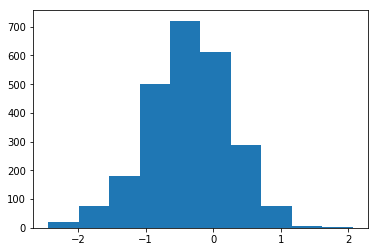

In [61]:
plt.hist(df_train["original_bias_score"])

### Dev

In [62]:
df_val = pd.read_csv(DATA_ROOT / config.val_file)

(array([ 1.,  4.,  4., 11., 38., 63., 66., 56., 29.,  4.]),
 array([-2.98104119, -2.5734925 , -2.16594381, -1.75839512, -1.35084643,
        -0.94329774, -0.53574905, -0.12820036,  0.27934833,  0.68689702,
         1.09444571]),
 <a list of 10 Patch objects>)

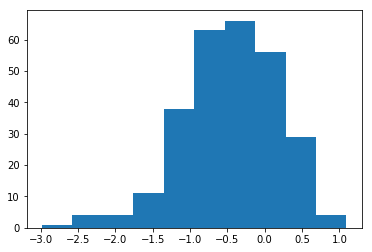

In [63]:
plt.hist(df_val["original_bias_score"])

# Training Loop

In [64]:
from allennlp.training import Callback

In [65]:
from copy import deepcopy

class StatisticRecorder(Callback):
    def __init__(self, orig_weights, rec_periods=1):
        self.rec_periods = rec_periods
        self.norms = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        self.grad_magnitudes = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        self._orig_weights = orig_weights
        self.change_magnitudes = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        
    def on_batch_end(self, data):
        if (data['batches_this_epoch'] + 1) % self.rec_periods == 0:
            with torch.no_grad():
                for k, p in self.trainer.model.named_parameters():
                    if p.requires_grad and p.grad is not None:
                        Z = torch.norm(p).item()
                        self.norms[k].append(Z)
                        self.grad_magnitudes[k].append((torch.norm(p.grad) / Z).item())
                        self.change_magnitudes[k].append((torch.norm(p - self._orig_weights[k]) / Z).item())

In [66]:
class WeightDeviationRegularizor(Callback):
    def __init__(self, orig_weights, weight=1e-4, l1=True):
        self.orig_weights = orig_weights
        self.weight = weight
        self.l1 = l1
        
    def get_reg_term(self, now, orig):
        if self.l1:
            return torch.where(now < orig, torch.ones_like(now), -torch.ones_like(now))
        else:
            return (orig - now)
        
    def on_backward_end(self, data):
        lr = config.lr
        with torch.no_grad():
            for name, param in self.trainer.model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    reg_term = self.weight * lr * self.get_reg_term(param.data, orig_weights[name])
                    param.data.add_(reg_term)

In [67]:
from collections import defaultdict
class LossMonitor(Callback):
    def __init__(self):
        super().__init__()
        self.logs = defaultdict(list)
    def on_forward_end(self, payload):
        for k, v in payload.items():
            if "loss" in k: self.logs[k].append(v.item())

In [68]:
stat_rec = StatisticRecorder(orig_weights, rec_periods=1)
wdd = WeightDeviationRegularizor(orig_weights, weight=config.weight_reg)
monitor = LossMonitor()

In [69]:
def use(name: str):
    if "LayerNorm" in name: return False
    if "position_embeddings" in name: return False
    if "token_type" in name: return False
    return True

In [70]:
filtered_params = [p for name, p in model.named_parameters() if use(name)]

In [71]:
optimizer = torch.optim.Adam(filtered_params, lr=config.lr, weight_decay=0.)

In [72]:
from allennlp.training.learning_rate_schedulers import SlantedTriangular, CosineWithRestarts
# use slanted triangular lr scheduler to prevent initial spike in consistency loss
lr_sched = SlantedTriangular(optimizer, 
                             num_epochs=config.epochs, 
                             num_steps_per_epoch=iterator.get_num_batches(train_ds))

In [73]:
from allennlp.training import TrainerWithCallbacks

trainer = TrainerWithCallbacks(
    model=model,
    optimizer=optimizer,
    iterator=iterator,
    train_dataset=train_ds,
    validation_dataset=val_ds,
    callbacks=[stat_rec, wdd, monitor],
    learning_rate_scheduler=lr_sched,
    #     serialization_dir=DATA_ROOT / "debias_ckpts",
    cuda_device=0 if torch.cuda.is_available() else -1,
    num_epochs=config.epochs,
)

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled


In [74]:
trainer.train()

  0%|          | 0/78 [00:00<?, ?it/s]

total_prob_diff: 0.0000, loss: 0.5046 ||:   1%|▏         | 1/78 [00:07<09:21,  7.30s/it]

total_prob_diff: -0.0001, loss: 0.5276 ||:   3%|▎         | 2/78 [00:14<09:02,  7.14s/it]

total_prob_diff: -0.0006, loss: 0.5161 ||:   4%|▍         | 3/78 [00:21<08:53,  7.12s/it]

total_prob_diff: -0.0004, loss: 0.5082 ||:   5%|▌         | 4/78 [00:28<08:46,  7.12s/it]

total_prob_diff: -0.0003, loss: 0.5222 ||:   6%|▋         | 5/78 [00:35<08:41,  7.15s/it]

total_prob_diff: -0.0003, loss: 0.5173 ||:   8%|▊         | 6/78 [00:43<08:58,  7.48s/it]

total_prob_diff: -0.0004, loss: 0.5056 ||:   9%|▉         | 7/78 [00:54<10:08,  8.57s/it]

total_prob_diff: -0.0003, loss: 0.5068 ||:  10%|█         | 8/78 [01:05<10:51,  9.31s/it]

total_prob_diff: -0.0003, loss: 0.5050 ||:  12%|█▏        | 9/78 [01:16<11:16,  9.80s/it]

total_prob_diff: -0.0003, loss: 0.4950 ||:  13%|█▎        | 10/78 [01:27<11:32, 10.18s/it]

total_prob_diff: -0.0004, loss: 0.4853 ||:  14%|█▍        | 11/78 [01:39<11:47, 10.55s/it]

total_prob_diff: -0.0003, loss: 0.4763 ||:  15%|█▌        | 12/78 [01:50<11:50, 10.77s/it]

total_prob_diff: -0.0008, loss: 0.4923 ||:  17%|█▋        | 13/78 [02:01<11:51, 10.94s/it]

total_prob_diff: -0.0008, loss: 0.4937 ||:  18%|█▊        | 14/78 [02:13<11:44, 11.01s/it]

total_prob_diff: -0.0007, loss: 0.4937 ||:  19%|█▉        | 15/78 [02:23<11:30, 10.97s/it]

total_prob_diff: -0.0006, loss: 0.4977 ||:  21%|██        | 16/78 [02:34<11:20, 10.97s/it]

total_prob_diff: -0.0006, loss: 0.4976 ||:  22%|██▏       | 17/78 [02:46<11:12, 11.03s/it]

total_prob_diff: -0.0007, loss: 0.5089 ||:  23%|██▎       | 18/78 [02:57<11:06, 11.11s/it]

total_prob_diff: -0.0006, loss: 0.5120 ||:  24%|██▍       | 19/78 [03:08<10:54, 11.10s/it]

total_prob_diff: -0.0006, loss: 0.5155 ||:  26%|██▌       | 20/78 [03:19<10:49, 11.20s/it]

total_prob_diff: -0.0003, loss: 0.5134 ||:  27%|██▋       | 21/78 [03:31<10:49, 11.39s/it]

total_prob_diff: -0.0002, loss: 0.5105 ||:  28%|██▊       | 22/78 [03:43<10:37, 11.38s/it]

total_prob_diff: -0.0001, loss: 0.5093 ||:  29%|██▉       | 23/78 [03:54<10:22, 11.33s/it]

total_prob_diff: -0.0003, loss: 0.5085 ||:  31%|███       | 24/78 [04:05<10:11, 11.32s/it]

total_prob_diff: -0.0006, loss: 0.5078 ||:  32%|███▏      | 25/78 [04:16<09:59, 11.31s/it]

total_prob_diff: -0.0007, loss: 0.5095 ||:  33%|███▎      | 26/78 [04:28<09:48, 11.32s/it]

total_prob_diff: -0.0008, loss: 0.5096 ||:  35%|███▍      | 27/78 [04:39<09:32, 11.23s/it]

total_prob_diff: -0.0008, loss: 0.5108 ||:  36%|███▌      | 28/78 [04:50<09:23, 11.27s/it]

total_prob_diff: -0.0007, loss: 0.5126 ||:  37%|███▋      | 29/78 [05:02<09:16, 11.36s/it]

total_prob_diff: -0.0007, loss: 0.5166 ||:  38%|███▊      | 30/78 [05:13<08:58, 11.22s/it]

total_prob_diff: -0.0011, loss: 0.5173 ||:  40%|███▉      | 31/78 [05:24<08:45, 11.18s/it]

total_prob_diff: -0.0011, loss: 0.5154 ||:  41%|████      | 32/78 [05:35<08:32, 11.14s/it]

total_prob_diff: -0.0010, loss: 0.5153 ||:  42%|████▏     | 33/78 [05:46<08:20, 11.12s/it]

total_prob_diff: -0.0010, loss: 0.5148 ||:  44%|████▎     | 34/78 [05:57<08:15, 11.26s/it]

total_prob_diff: -0.0010, loss: 0.5138 ||:  45%|████▍     | 35/78 [06:09<08:06, 11.30s/it]

total_prob_diff: -0.0012, loss: 0.5145 ||:  46%|████▌     | 36/78 [06:20<07:56, 11.34s/it]

total_prob_diff: -0.0011, loss: 0.5152 ||:  47%|████▋     | 37/78 [06:31<07:41, 11.27s/it]

total_prob_diff: -0.0012, loss: 0.5154 ||:  49%|████▊     | 38/78 [06:43<07:31, 11.28s/it]

total_prob_diff: -0.0013, loss: 0.5139 ||:  50%|█████     | 39/78 [06:54<07:18, 11.25s/it]

total_prob_diff: -0.0013, loss: 0.5125 ||:  51%|█████▏    | 40/78 [07:05<07:11, 11.37s/it]

total_prob_diff: -0.0013, loss: 0.5111 ||:  53%|█████▎    | 41/78 [07:17<06:58, 11.32s/it]

total_prob_diff: -0.0013, loss: 0.5104 ||:  54%|█████▍    | 42/78 [07:28<06:49, 11.38s/it]

total_prob_diff: -0.0011, loss: 0.5117 ||:  55%|█████▌    | 43/78 [07:40<06:38, 11.38s/it]

total_prob_diff: -0.0011, loss: 0.5097 ||:  56%|█████▋    | 44/78 [07:51<06:23, 11.27s/it]

total_prob_diff: -0.0012, loss: 0.5082 ||:  58%|█████▊    | 45/78 [08:02<06:13, 11.31s/it]

total_prob_diff: -0.0011, loss: 0.5075 ||:  59%|█████▉    | 46/78 [08:13<05:59, 11.24s/it]

total_prob_diff: -0.0011, loss: 0.5052 ||:  60%|██████    | 47/78 [08:24<05:48, 11.23s/it]

total_prob_diff: -0.0013, loss: 0.5045 ||:  62%|██████▏   | 48/78 [08:36<05:37, 11.25s/it]

total_prob_diff: -0.0013, loss: 0.5030 ||:  63%|██████▎   | 49/78 [08:47<05:26, 11.25s/it]

total_prob_diff: -0.0013, loss: 0.5002 ||:  64%|██████▍   | 50/78 [08:58<05:17, 11.34s/it]

total_prob_diff: -0.0014, loss: 0.4982 ||:  65%|██████▌   | 51/78 [09:10<05:06, 11.35s/it]

total_prob_diff: -0.0015, loss: 0.4961 ||:  67%|██████▋   | 52/78 [09:21<04:55, 11.36s/it]

total_prob_diff: -0.0015, loss: 0.4946 ||:  68%|██████▊   | 53/78 [09:33<04:47, 11.51s/it]

total_prob_diff: -0.0015, loss: 0.4926 ||:  69%|██████▉   | 54/78 [09:44<04:36, 11.50s/it]

total_prob_diff: -0.0014, loss: 0.4905 ||:  71%|███████   | 55/78 [09:56<04:26, 11.57s/it]

total_prob_diff: -0.0012, loss: 0.4876 ||:  72%|███████▏  | 56/78 [10:08<04:13, 11.54s/it]

total_prob_diff: -0.0012, loss: 0.4858 ||:  73%|███████▎  | 57/78 [10:19<03:59, 11.43s/it]

total_prob_diff: -0.0012, loss: 0.4833 ||:  74%|███████▍  | 58/78 [10:31<03:52, 11.61s/it]

total_prob_diff: -0.0011, loss: 0.4817 ||:  76%|███████▌  | 59/78 [10:43<03:40, 11.62s/it]

total_prob_diff: -0.0011, loss: 0.4803 ||:  77%|███████▋  | 60/78 [10:55<03:31, 11.75s/it]

total_prob_diff: -0.0011, loss: 0.4789 ||:  78%|███████▊  | 61/78 [11:06<03:17, 11.64s/it]

total_prob_diff: -0.0011, loss: 0.4773 ||:  79%|███████▉  | 62/78 [11:17<03:04, 11.56s/it]

total_prob_diff: -0.0011, loss: 0.4754 ||:  81%|████████  | 63/78 [11:29<02:55, 11.68s/it]

total_prob_diff: -0.0011, loss: 0.4746 ||:  82%|████████▏ | 64/78 [11:42<02:45, 11.86s/it]

total_prob_diff: -0.0011, loss: 0.4727 ||:  83%|████████▎ | 65/78 [11:56<02:45, 12.74s/it]

total_prob_diff: -0.0012, loss: 0.4718 ||:  85%|████████▍ | 66/78 [12:10<02:36, 13.03s/it]

total_prob_diff: -0.0012, loss: 0.4713 ||:  86%|████████▌ | 67/78 [12:22<02:19, 12.73s/it]

total_prob_diff: -0.0013, loss: 0.4717 ||:  87%|████████▋ | 68/78 [12:34<02:04, 12.45s/it]

total_prob_diff: -0.0013, loss: 0.4705 ||:  88%|████████▊ | 69/78 [12:46<01:51, 12.36s/it]

total_prob_diff: -0.0013, loss: 0.4686 ||:  90%|████████▉ | 70/78 [12:59<01:39, 12.40s/it]

total_prob_diff: -0.0013, loss: 0.4686 ||:  91%|█████████ | 71/78 [13:11<01:26, 12.33s/it]

total_prob_diff: -0.0012, loss: 0.4668 ||:  92%|█████████▏| 72/78 [13:24<01:15, 12.58s/it]

total_prob_diff: -0.0012, loss: 0.4659 ||:  94%|█████████▎| 73/78 [13:37<01:03, 12.70s/it]

total_prob_diff: -0.0012, loss: 0.4651 ||:  95%|█████████▍| 74/78 [13:49<00:50, 12.59s/it]

total_prob_diff: -0.0012, loss: 0.4643 ||:  96%|█████████▌| 75/78 [14:01<00:37, 12.48s/it]

total_prob_diff: -0.0011, loss: 0.4630 ||:  97%|█████████▋| 76/78 [14:16<00:26, 13.21s/it]

total_prob_diff: -0.0011, loss: 0.4622 ||:  99%|█████████▊| 77/78 [14:32<00:13, 13.92s/it]

total_prob_diff: -0.0011, loss: 0.4607 ||: 100%|██████████| 78/78 [14:45<00:00, 13.55s/it]


  0%|          | 0/9 [00:00<?, ?it/s]

total_prob_diff: -0.0011, loss: 0.3292 ||:  11%|█         | 1/9 [00:02<00:21,  2.69s/it]

total_prob_diff: -0.0012, loss: 0.4210 ||:  22%|██▏       | 2/9 [00:05<00:18,  2.70s/it]

total_prob_diff: -0.0011, loss: 0.4681 ||:  33%|███▎      | 3/9 [00:08<00:16,  2.72s/it]

total_prob_diff: -0.0011, loss: 0.4546 ||:  44%|████▍     | 4/9 [00:11<00:13,  2.79s/it]

total_prob_diff: -0.0012, loss: 0.4342 ||:  56%|█████▌    | 5/9 [00:14<00:11,  2.84s/it]

total_prob_diff: -0.0012, loss: 0.4103 ||:  67%|██████▋   | 6/9 [00:16<00:08,  2.83s/it]

total_prob_diff: -0.0013, loss: 0.4095 ||:  78%|███████▊  | 7/9 [00:19<00:05,  2.85s/it]

total_prob_diff: -0.0013, loss: 0.4149 ||:  89%|████████▉ | 8/9 [00:22<00:02,  2.79s/it]

total_prob_diff: -0.0013, loss: 0.4074 ||: 100%|██████████| 9/9 [00:24<00:00,  2.48s/it]

  0%|          | 0/78 [00:00<?, ?it/s]

total_prob_diff: -0.0013, loss: 0.2946 ||:   1%|▏         | 1/78 [00:12<16:09, 12.60s/it]

total_prob_diff: -0.0013, loss: 0.3291 ||:   3%|▎         | 2/78 [00:20<14:05, 11.12s/it]

total_prob_diff: -0.0013, loss: 0.3544 ||:   4%|▍         | 3/78 [00:27<12:15,  9.81s/it]

total_prob_diff: -0.0013, loss: 0.3365 ||:   5%|▌         | 4/78 [00:34<11:03,  8.97s/it]

total_prob_diff: -0.0013, loss: 0.3454 ||:   6%|▋         | 5/78 [00:41<10:15,  8.43s/it]

total_prob_diff: -0.0013, loss: 0.3472 ||:   8%|▊         | 6/78 [00:48<09:40,  8.07s/it]

total_prob_diff: -0.0013, loss: 0.3611 ||:   9%|▉         | 7/78 [00:55<09:07,  7.71s/it]

total_prob_diff: -0.0013, loss: 0.3508 ||:  10%|█         | 8/78 [01:02<08:41,  7.46s/it]

total_prob_diff: -0.0012, loss: 0.3502 ||:  12%|█▏        | 9/78 [01:09<08:27,  7.35s/it]

total_prob_diff: -0.0012, loss: 0.3512 ||:  13%|█▎        | 10/78 [01:16<08:18,  7.33s/it]

total_prob_diff: -0.0012, loss: 0.3533 ||:  14%|█▍        | 11/78 [01:23<08:06,  7.26s/it]

total_prob_diff: -0.0012, loss: 0.3574 ||:  15%|█▌        | 12/78 [01:31<08:02,  7.30s/it]

total_prob_diff: -0.0012, loss: 0.3548 ||:  17%|█▋        | 13/78 [01:38<08:02,  7.42s/it]

total_prob_diff: -0.0012, loss: 0.3530 ||:  18%|█▊        | 14/78 [01:45<07:50,  7.35s/it]

total_prob_diff: -0.0012, loss: 0.3552 ||:  19%|█▉        | 15/78 [01:52<07:35,  7.23s/it]

total_prob_diff: -0.0012, loss: 0.3559 ||:  21%|██        | 16/78 [02:00<07:29,  7.25s/it]

total_prob_diff: -0.0012, loss: 0.3525 ||:  22%|██▏       | 17/78 [02:07<07:25,  7.31s/it]

total_prob_diff: -0.0013, loss: 0.3569 ||:  23%|██▎       | 18/78 [02:14<07:16,  7.28s/it]

total_prob_diff: -0.0013, loss: 0.3572 ||:  24%|██▍       | 19/78 [02:22<07:08,  7.27s/it]

total_prob_diff: -0.0013, loss: 0.3572 ||:  26%|██▌       | 20/78 [02:30<07:14,  7.49s/it]

total_prob_diff: -0.0014, loss: 0.3560 ||:  27%|██▋       | 21/78 [02:38<07:18,  7.69s/it]

total_prob_diff: -0.0014, loss: 0.3568 ||:  28%|██▊       | 22/78 [02:49<08:10,  8.76s/it]

total_prob_diff: -0.0014, loss: 0.3543 ||:  29%|██▉       | 23/78 [03:01<08:51,  9.67s/it]

total_prob_diff: -0.0013, loss: 0.3522 ||:  31%|███       | 24/78 [03:12<09:10, 10.19s/it]

total_prob_diff: -0.0014, loss: 0.3496 ||:  32%|███▏      | 25/78 [03:24<09:18, 10.54s/it]

total_prob_diff: -0.0014, loss: 0.3483 ||:  33%|███▎      | 26/78 [03:35<09:25, 10.88s/it]

total_prob_diff: -0.0014, loss: 0.3458 ||:  35%|███▍      | 27/78 [03:46<09:14, 10.87s/it]

total_prob_diff: -0.0014, loss: 0.3448 ||:  36%|███▌      | 28/78 [03:57<09:05, 10.92s/it]

total_prob_diff: -0.0013, loss: 0.3462 ||:  37%|███▋      | 29/78 [04:09<09:08, 11.20s/it]

total_prob_diff: -0.0013, loss: 0.3481 ||:  38%|███▊      | 30/78 [04:21<09:07, 11.40s/it]

total_prob_diff: -0.0013, loss: 0.3459 ||:  40%|███▉      | 31/78 [04:32<08:59, 11.47s/it]

total_prob_diff: -0.0013, loss: 0.3459 ||:  41%|████      | 32/78 [04:44<08:51, 11.55s/it]

total_prob_diff: -0.0012, loss: 0.3458 ||:  42%|████▏     | 33/78 [04:56<08:47, 11.72s/it]

total_prob_diff: -0.0012, loss: 0.3479 ||:  44%|████▎     | 34/78 [05:08<08:39, 11.80s/it]

total_prob_diff: -0.0012, loss: 0.3481 ||:  45%|████▍     | 35/78 [05:20<08:26, 11.77s/it]

total_prob_diff: -0.0012, loss: 0.3506 ||:  46%|████▌     | 36/78 [05:31<08:08, 11.63s/it]

total_prob_diff: -0.0012, loss: 0.3500 ||:  47%|████▋     | 37/78 [05:43<07:52, 11.53s/it]

total_prob_diff: -0.0012, loss: 0.3490 ||:  49%|████▊     | 38/78 [05:54<07:36, 11.41s/it]

total_prob_diff: -0.0012, loss: 0.3516 ||:  50%|█████     | 39/78 [06:05<07:22, 11.36s/it]

total_prob_diff: -0.0012, loss: 0.3508 ||:  51%|█████▏    | 40/78 [06:16<07:09, 11.31s/it]

total_prob_diff: -0.0013, loss: 0.3504 ||:  53%|█████▎    | 41/78 [06:27<06:57, 11.28s/it]

total_prob_diff: -0.0012, loss: 0.3499 ||:  54%|█████▍    | 42/78 [06:39<06:44, 11.24s/it]

total_prob_diff: -0.0012, loss: 0.3491 ||:  55%|█████▌    | 43/78 [06:50<06:31, 11.19s/it]

total_prob_diff: -0.0012, loss: 0.3507 ||:  56%|█████▋    | 44/78 [07:01<06:20, 11.19s/it]

total_prob_diff: -0.0012, loss: 0.3490 ||:  58%|█████▊    | 45/78 [07:12<06:12, 11.28s/it]

total_prob_diff: -0.0012, loss: 0.3494 ||:  59%|█████▉    | 46/78 [07:24<06:00, 11.27s/it]

total_prob_diff: -0.0011, loss: 0.3479 ||:  60%|██████    | 47/78 [07:35<05:52, 11.36s/it]

total_prob_diff: -0.0011, loss: 0.3474 ||:  62%|██████▏   | 48/78 [07:47<05:42, 11.40s/it]

total_prob_diff: -0.0011, loss: 0.3465 ||:  63%|██████▎   | 49/78 [07:58<05:32, 11.48s/it]

total_prob_diff: -0.0011, loss: 0.3467 ||:  64%|██████▍   | 50/78 [08:10<05:23, 11.54s/it]

total_prob_diff: -0.0012, loss: 0.3464 ||:  65%|██████▌   | 51/78 [08:21<05:11, 11.53s/it]

total_prob_diff: -0.0011, loss: 0.3477 ||:  67%|██████▋   | 52/78 [08:34<05:05, 11.76s/it]

total_prob_diff: -0.0011, loss: 0.3471 ||:  68%|██████▊   | 53/78 [08:46<05:01, 12.04s/it]

total_prob_diff: -0.0012, loss: 0.3481 ||:  69%|██████▉   | 54/78 [08:58<04:46, 11.93s/it]

total_prob_diff: -0.0012, loss: 0.3473 ||:  71%|███████   | 55/78 [09:10<04:32, 11.85s/it]

total_prob_diff: -0.0012, loss: 0.3469 ||:  72%|███████▏  | 56/78 [09:21<04:19, 11.81s/it]

total_prob_diff: -0.0013, loss: 0.3462 ||:  73%|███████▎  | 57/78 [09:33<04:07, 11.76s/it]

total_prob_diff: -0.0013, loss: 0.3455 ||:  74%|███████▍  | 58/78 [09:44<03:51, 11.60s/it]

total_prob_diff: -0.0013, loss: 0.3449 ||:  76%|███████▌  | 59/78 [09:56<03:40, 11.58s/it]

total_prob_diff: -0.0013, loss: 0.3441 ||:  77%|███████▋  | 60/78 [10:07<03:27, 11.52s/it]

total_prob_diff: -0.0013, loss: 0.3439 ||:  78%|███████▊  | 61/78 [10:18<03:14, 11.41s/it]

total_prob_diff: -0.0013, loss: 0.3433 ||:  79%|███████▉  | 62/78 [10:30<03:02, 11.41s/it]

total_prob_diff: -0.0012, loss: 0.3430 ||:  81%|████████  | 63/78 [10:41<02:51, 11.42s/it]

total_prob_diff: -0.0012, loss: 0.3429 ||:  82%|████████▏ | 64/78 [10:53<02:39, 11.38s/it]

total_prob_diff: -0.0012, loss: 0.3429 ||:  83%|████████▎ | 65/78 [11:04<02:27, 11.32s/it]

total_prob_diff: -0.0012, loss: 0.3422 ||:  85%|████████▍ | 66/78 [11:16<02:18, 11.54s/it]

total_prob_diff: -0.0012, loss: 0.3425 ||:  86%|████████▌ | 67/78 [11:28<02:07, 11.63s/it]

total_prob_diff: -0.0012, loss: 0.3423 ||:  87%|████████▋ | 68/78 [11:39<01:56, 11.69s/it]

total_prob_diff: -0.0012, loss: 0.3416 ||:  88%|████████▊ | 69/78 [11:51<01:45, 11.72s/it]

total_prob_diff: -0.0012, loss: 0.3408 ||:  90%|████████▉ | 70/78 [12:03<01:33, 11.64s/it]

total_prob_diff: -0.0012, loss: 0.3400 ||:  91%|█████████ | 71/78 [12:14<01:20, 11.53s/it]

total_prob_diff: -0.0012, loss: 0.3394 ||:  92%|█████████▏| 72/78 [12:25<01:08, 11.45s/it]

total_prob_diff: -0.0012, loss: 0.3389 ||:  94%|█████████▎| 73/78 [12:37<00:57, 11.42s/it]

total_prob_diff: -0.0012, loss: 0.3380 ||:  95%|█████████▍| 74/78 [12:48<00:45, 11.40s/it]

total_prob_diff: -0.0012, loss: 0.3374 ||:  96%|█████████▌| 75/78 [12:59<00:33, 11.32s/it]

total_prob_diff: -0.0012, loss: 0.3372 ||:  97%|█████████▋| 76/78 [13:10<00:22, 11.27s/it]

total_prob_diff: -0.0011, loss: 0.3376 ||:  99%|█████████▊| 77/78 [13:21<00:11, 11.16s/it]

total_prob_diff: -0.0011, loss: 0.3373 ||: 100%|██████████| 78/78 [13:29<00:00, 10.29s/it]


  0%|          | 0/9 [00:00<?, ?it/s]

total_prob_diff: -0.0011, loss: 0.3358 ||:  11%|█         | 1/9 [00:02<00:18,  2.35s/it]

total_prob_diff: -0.0011, loss: 0.3808 ||:  22%|██▏       | 2/9 [00:04<00:16,  2.35s/it]

total_prob_diff: -0.0011, loss: 0.4364 ||:  33%|███▎      | 3/9 [00:07<00:14,  2.37s/it]

total_prob_diff: -0.0010, loss: 0.4118 ||:  44%|████▍     | 4/9 [00:09<00:11,  2.39s/it]

total_prob_diff: -0.0010, loss: 0.3829 ||:  56%|█████▌    | 5/9 [00:11<00:09,  2.39s/it]

total_prob_diff: -0.0010, loss: 0.3628 ||:  67%|██████▋   | 6/9 [00:14<00:07,  2.40s/it]

total_prob_diff: -0.0010, loss: 0.3762 ||:  78%|███████▊  | 7/9 [00:16<00:04,  2.43s/it]

total_prob_diff: -0.0010, loss: 0.3845 ||:  89%|████████▉ | 8/9 [00:19<00:02,  2.42s/it]

total_prob_diff: -0.0010, loss: 0.3774 ||: 100%|██████████| 9/9 [00:20<00:00,  2.15s/it]


  0%|          | 0/78 [00:00<?, ?it/s]

total_prob_diff: -0.0010, loss: 0.2530 ||:   1%|▏         | 1/78 [00:12<15:55, 12.41s/it]

total_prob_diff: -0.0010, loss: 0.2551 ||:   3%|▎         | 2/78 [00:23<15:21, 12.12s/it]

total_prob_diff: -0.0010, loss: 0.2691 ||:   4%|▍         | 3/78 [00:35<14:55, 11.94s/it]

total_prob_diff: -0.0010, loss: 0.2688 ||:   5%|▌         | 4/78 [00:46<14:34, 11.81s/it]

total_prob_diff: -0.0010, loss: 0.2758 ||:   6%|▋         | 5/78 [00:58<14:07, 11.61s/it]

total_prob_diff: -0.0010, loss: 0.2747 ||:   8%|▊         | 6/78 [01:09<13:49, 11.52s/it]

total_prob_diff: -0.0010, loss: 0.2766 ||:   9%|▉         | 7/78 [01:20<13:31, 11.44s/it]

total_prob_diff: -0.0010, loss: 0.2727 ||:  10%|█         | 8/78 [01:32<13:24, 11.49s/it]

total_prob_diff: -0.0010, loss: 0.2740 ||:  12%|█▏        | 9/78 [01:43<13:11, 11.47s/it]

total_prob_diff: -0.0009, loss: 0.2802 ||:  13%|█▎        | 10/78 [01:55<13:00, 11.48s/it]

total_prob_diff: -0.0010, loss: 0.2804 ||:  14%|█▍        | 11/78 [02:06<12:49, 11.48s/it]

total_prob_diff: -0.0010, loss: 0.2810 ||:  15%|█▌        | 12/78 [02:17<12:31, 11.38s/it]

total_prob_diff: -0.0010, loss: 0.2747 ||:  17%|█▋        | 13/78 [02:26<11:21, 10.48s/it]

total_prob_diff: -0.0010, loss: 0.2770 ||:  18%|█▊        | 14/78 [02:34<10:22,  9.72s/it]

total_prob_diff: -0.0009, loss: 0.2757 ||:  19%|█▉        | 15/78 [02:41<09:35,  9.14s/it]

total_prob_diff: -0.0009, loss: 0.2737 ||:  21%|██        | 16/78 [02:49<08:58,  8.68s/it]

total_prob_diff: -0.0009, loss: 0.2720 ||:  22%|██▏       | 17/78 [02:57<08:34,  8.44s/it]

total_prob_diff: -0.0009, loss: 0.2720 ||:  23%|██▎       | 18/78 [03:05<08:20,  8.34s/it]

total_prob_diff: -0.0009, loss: 0.2708 ||:  24%|██▍       | 19/78 [03:13<08:11,  8.33s/it]

total_prob_diff: -0.0009, loss: 0.2694 ||:  26%|██▌       | 20/78 [03:21<07:58,  8.25s/it]

total_prob_diff: -0.0009, loss: 0.2684 ||:  27%|██▋       | 21/78 [03:29<07:49,  8.23s/it]

total_prob_diff: -0.0009, loss: 0.2725 ||:  28%|██▊       | 22/78 [03:41<08:33,  9.17s/it]

total_prob_diff: -0.0009, loss: 0.2749 ||:  29%|██▉       | 23/78 [03:52<08:56,  9.75s/it]

total_prob_diff: -0.0009, loss: 0.2744 ||:  31%|███       | 24/78 [04:03<09:12, 10.23s/it]

total_prob_diff: -0.0009, loss: 0.2732 ||:  32%|███▏      | 25/78 [04:15<09:24, 10.65s/it]

total_prob_diff: -0.0009, loss: 0.2718 ||:  33%|███▎      | 26/78 [04:27<09:28, 10.93s/it]

total_prob_diff: -0.0009, loss: 0.2728 ||:  35%|███▍      | 27/78 [04:38<09:22, 11.04s/it]

total_prob_diff: -0.0009, loss: 0.2721 ||:  36%|███▌      | 28/78 [04:49<09:17, 11.15s/it]

total_prob_diff: -0.0009, loss: 0.2718 ||:  37%|███▋      | 29/78 [05:01<09:21, 11.45s/it]

total_prob_diff: -0.0009, loss: 0.2707 ||:  38%|███▊      | 30/78 [05:16<09:48, 12.27s/it]

total_prob_diff: -0.0009, loss: 0.2703 ||:  40%|███▉      | 31/78 [05:27<09:20, 11.92s/it]

total_prob_diff: -0.0009, loss: 0.2705 ||:  41%|████      | 32/78 [05:38<08:54, 11.63s/it]

total_prob_diff: -0.0009, loss: 0.2714 ||:  42%|████▏     | 33/78 [05:49<08:37, 11.50s/it]

total_prob_diff: -0.0009, loss: 0.2721 ||:  44%|████▎     | 34/78 [06:00<08:23, 11.45s/it]

total_prob_diff: -0.0009, loss: 0.2739 ||:  45%|████▍     | 35/78 [06:12<08:13, 11.47s/it]

total_prob_diff: -0.0009, loss: 0.2726 ||:  46%|████▌     | 36/78 [06:23<07:58, 11.40s/it]

total_prob_diff: -0.0009, loss: 0.2719 ||:  47%|████▋     | 37/78 [06:34<07:44, 11.33s/it]

total_prob_diff: -0.0009, loss: 0.2704 ||:  49%|████▊     | 38/78 [06:45<07:32, 11.30s/it]

total_prob_diff: -0.0009, loss: 0.2703 ||:  50%|█████     | 39/78 [06:57<07:19, 11.27s/it]

total_prob_diff: -0.0009, loss: 0.2696 ||:  51%|█████▏    | 40/78 [07:08<07:08, 11.27s/it]

total_prob_diff: -0.0009, loss: 0.2682 ||:  53%|█████▎    | 41/78 [07:19<06:54, 11.21s/it]

total_prob_diff: -0.0009, loss: 0.2672 ||:  54%|█████▍    | 42/78 [07:30<06:43, 11.20s/it]

total_prob_diff: -0.0009, loss: 0.2671 ||:  55%|█████▌    | 43/78 [07:41<06:31, 11.18s/it]

total_prob_diff: -0.0009, loss: 0.2668 ||:  56%|█████▋    | 44/78 [07:53<06:31, 11.52s/it]

total_prob_diff: -0.0009, loss: 0.2656 ||:  58%|█████▊    | 45/78 [08:05<06:21, 11.57s/it]

total_prob_diff: -0.0009, loss: 0.2641 ||:  59%|█████▉    | 46/78 [08:17<06:10, 11.58s/it]

total_prob_diff: -0.0009, loss: 0.2628 ||:  60%|██████    | 47/78 [08:28<05:53, 11.41s/it]

total_prob_diff: -0.0009, loss: 0.2618 ||:  62%|██████▏   | 48/78 [08:39<05:40, 11.34s/it]

total_prob_diff: -0.0009, loss: 0.2601 ||:  63%|██████▎   | 49/78 [08:50<05:26, 11.26s/it]

total_prob_diff: -0.0009, loss: 0.2606 ||:  64%|██████▍   | 50/78 [09:01<05:12, 11.16s/it]

total_prob_diff: -0.0009, loss: 0.2606 ||:  65%|██████▌   | 51/78 [09:12<05:00, 11.14s/it]

total_prob_diff: -0.0009, loss: 0.2603 ||:  67%|██████▋   | 52/78 [09:24<04:55, 11.35s/it]

total_prob_diff: -0.0009, loss: 0.2609 ||:  68%|██████▊   | 53/78 [09:36<04:46, 11.47s/it]

total_prob_diff: -0.0009, loss: 0.2610 ||:  69%|██████▉   | 54/78 [09:47<04:35, 11.48s/it]

total_prob_diff: -0.0009, loss: 0.2605 ||:  71%|███████   | 55/78 [09:59<04:24, 11.52s/it]

total_prob_diff: -0.0009, loss: 0.2606 ||:  72%|███████▏  | 56/78 [10:10<04:13, 11.53s/it]

total_prob_diff: -0.0009, loss: 0.2601 ||:  73%|███████▎  | 57/78 [10:22<04:05, 11.71s/it]

total_prob_diff: -0.0009, loss: 0.2600 ||:  74%|███████▍  | 58/78 [10:34<03:52, 11.64s/it]

total_prob_diff: -0.0009, loss: 0.2595 ||:  76%|███████▌  | 59/78 [10:44<03:33, 11.24s/it]

total_prob_diff: -0.0009, loss: 0.2593 ||:  77%|███████▋  | 60/78 [10:54<03:13, 10.73s/it]

total_prob_diff: -0.0009, loss: 0.2587 ||:  78%|███████▊  | 61/78 [11:04<03:00, 10.64s/it]

total_prob_diff: -0.0009, loss: 0.2588 ||:  79%|███████▉  | 62/78 [11:13<02:42, 10.16s/it]

total_prob_diff: -0.0009, loss: 0.2578 ||:  81%|████████  | 63/78 [11:23<02:31, 10.09s/it]

total_prob_diff: -0.0009, loss: 0.2573 ||:  82%|████████▏ | 64/78 [11:35<02:28, 10.63s/it]

total_prob_diff: -0.0009, loss: 0.2570 ||:  83%|████████▎ | 65/78 [11:48<02:26, 11.27s/it]

total_prob_diff: -0.0009, loss: 0.2562 ||:  85%|████████▍ | 66/78 [12:01<02:21, 11.81s/it]

total_prob_diff: -0.0009, loss: 0.2561 ||:  86%|████████▌ | 67/78 [12:15<02:16, 12.43s/it]

total_prob_diff: -0.0009, loss: 0.2557 ||:  87%|████████▋ | 68/78 [12:27<02:03, 12.40s/it]

total_prob_diff: -0.0009, loss: 0.2548 ||:  88%|████████▊ | 69/78 [12:39<01:51, 12.33s/it]

total_prob_diff: -0.0009, loss: 0.2542 ||:  90%|████████▉ | 70/78 [12:52<01:39, 12.39s/it]

total_prob_diff: -0.0009, loss: 0.2546 ||:  91%|█████████ | 71/78 [13:04<01:25, 12.28s/it]

total_prob_diff: -0.0009, loss: 0.2541 ||:  92%|█████████▏| 72/78 [13:15<01:12, 12.09s/it]

total_prob_diff: -0.0009, loss: 0.2534 ||:  94%|█████████▎| 73/78 [13:27<01:00, 12.03s/it]

total_prob_diff: -0.0009, loss: 0.2531 ||:  95%|█████████▍| 74/78 [13:39<00:47, 11.97s/it]

total_prob_diff: -0.0009, loss: 0.2530 ||:  96%|█████████▌| 75/78 [13:51<00:35, 11.81s/it]

total_prob_diff: -0.0009, loss: 0.2521 ||:  97%|█████████▋| 76/78 [14:02<00:23, 11.63s/it]

total_prob_diff: -0.0009, loss: 0.2516 ||:  99%|█████████▊| 77/78 [14:13<00:11, 11.51s/it]

total_prob_diff: -0.0009, loss: 0.2514 ||: 100%|██████████| 78/78 [14:22<00:00, 10.60s/it]


  0%|          | 0/9 [00:00<?, ?it/s]

total_prob_diff: -0.0009, loss: 0.2565 ||:  11%|█         | 1/9 [00:02<00:18,  2.37s/it]

total_prob_diff: -0.0009, loss: 0.3454 ||:  22%|██▏       | 2/9 [00:04<00:16,  2.37s/it]

total_prob_diff: -0.0009, loss: 0.3991 ||:  33%|███▎      | 3/9 [00:07<00:14,  2.39s/it]

total_prob_diff: -0.0009, loss: 0.3725 ||:  44%|████▍     | 4/9 [00:09<00:12,  2.41s/it]

total_prob_diff: -0.0009, loss: 0.3448 ||:  56%|█████▌    | 5/9 [00:12<00:09,  2.41s/it]

total_prob_diff: -0.0009, loss: 0.3221 ||:  67%|██████▋   | 6/9 [00:14<00:07,  2.43s/it]

total_prob_diff: -0.0009, loss: 0.3339 ||:  78%|███████▊  | 7/9 [00:17<00:04,  2.44s/it]

total_prob_diff: -0.0009, loss: 0.3445 ||:  89%|████████▉ | 8/9 [00:19<00:02,  2.42s/it]

total_prob_diff: -0.0009, loss: 0.3468 ||: 100%|██████████| 9/9 [00:20<00:00,  2.16s/it]

{'best_epoch': 2,
 'peak_cpu_memory_MB': 4964.0448,
 'training_duration': '00:43:43',
 'training_start_epoch': 0,
 'training_epochs': 2,
 'epoch': 2,
 'training_total_prob_diff': -0.0008780707931615706,
 'training_loss': 0.25135150647316223,
 'training_cpu_memory_MB': 4964.0448,
 'validation_total_prob_diff': -0.0008525636882824828,
 'validation_loss': 0.3467799805932575,
 'best_validation_total_prob_diff': -0.0008525636882824828,
 'best_validation_loss': 0.3467799805932575}

Analyzing changes

In [75]:
change_sorted_weights = sorted([(-v[-1], k) for k, v in stat_rec.change_magnitudes.items() if len(v) > 0])
{k.replace("bert_for_masked_lm.bert.encoder.", ""): -x for x, k in change_sorted_weights}

{'layer.11.attention.self.value.bias': 0.0022987083066254854,
 'layer.11.attention.self.query.weight': 0.001912881969474256,
 'layer.11.intermediate.dense.weight': 0.0019025293877348304,
 'layer.11.attention.self.key.weight': 0.0018669019918888807,
 'layer.11.attention.output.dense.weight': 0.0018408476607874036,
 'layer.10.intermediate.dense.weight': 0.001753163873218,
 'layer.10.attention.output.dense.weight': 0.0017374252201989293,
 'layer.9.attention.output.dense.weight': 0.0016938793705776334,
 'layer.11.attention.self.value.weight': 0.0016752686351537704,
 'layer.7.attention.output.dense.weight': 0.001624982338398695,
 'layer.9.intermediate.dense.weight': 0.0015904625179246068,
 'layer.8.attention.output.dense.weight': 0.0015543868066743016,
 'layer.10.attention.self.value.weight': 0.001539650373160839,
 'layer.10.attention.self.value.bias': 0.0015183406649157405,
 'layer.9.attention.self.value.weight': 0.0014777163742110133,
 'layer.7.attention.self.value.weight': 0.001460590632

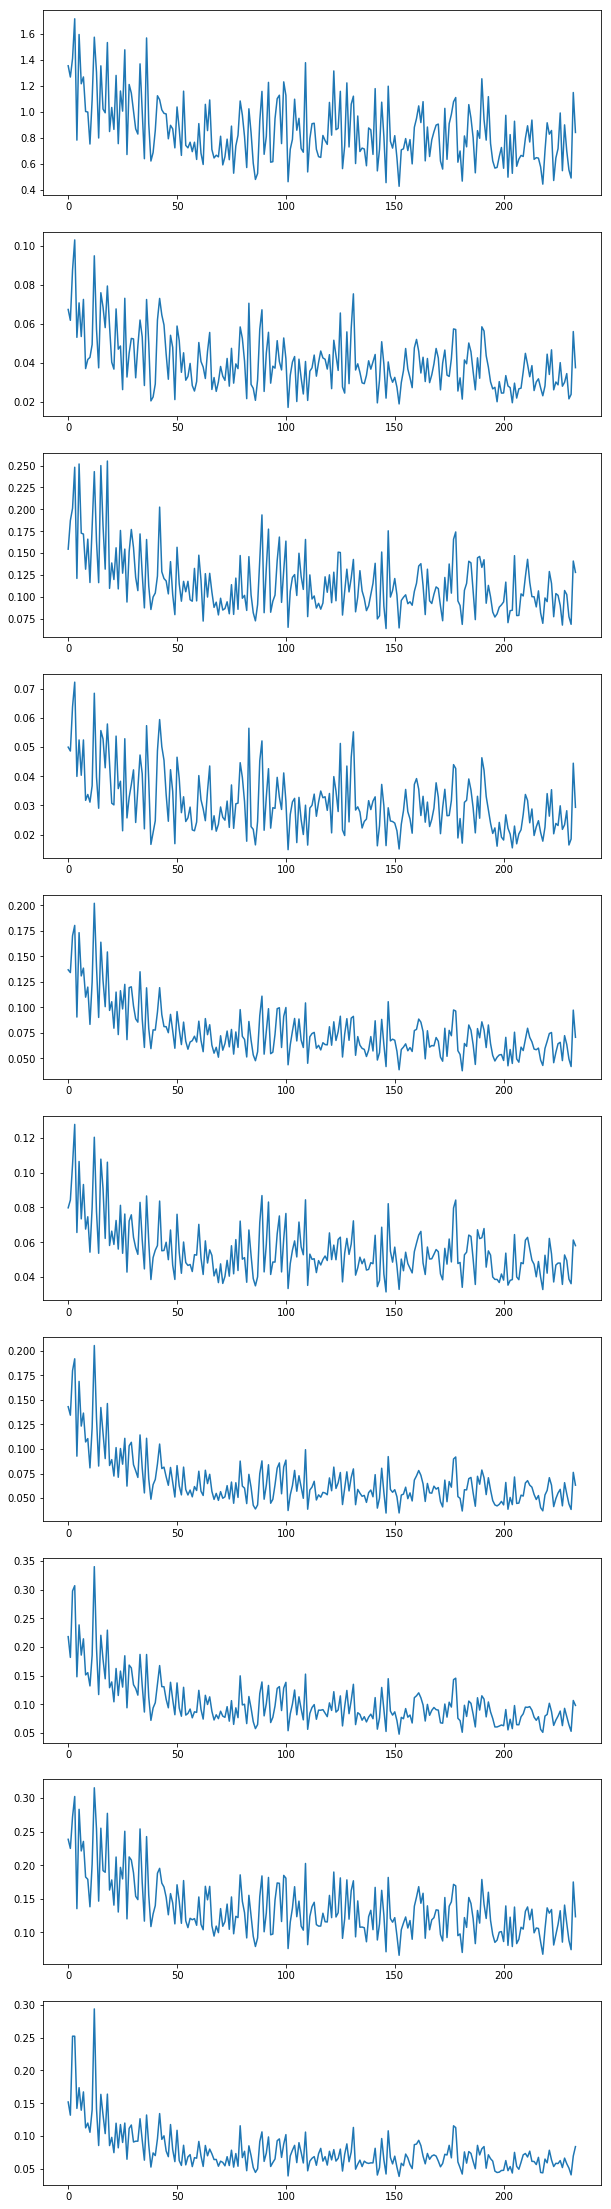

In [76]:
n = 10
fig = plt.figure(figsize=(10, n * 4))
for i, (_, k) in enumerate(change_sorted_weights[:n]):
    ax = fig.add_subplot(n, 1, i+1)
    ax.plot(stat_rec.grad_magnitudes[k])

### Change in loss breakdown

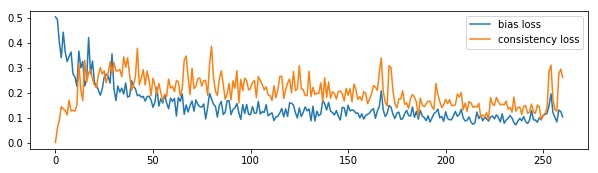

In [77]:
fig = plt.figure(figsize=(10, 30))
ax = fig.add_subplot(n, 1, 1)
ax.plot(monitor.logs["bias_loss"], label="bias loss")
ax.plot(monitor.logs["consistency_loss"], label="consistency loss")
ax.legend()

# Evaluate

Simple prediction

In [78]:
def get_preds(model, batch: TensorDict):
    return model(**batch)["logits"].argmax(2)

In [79]:
to_words(batch["input"]["tokens"])

['[CLS] [MASK] is discreet [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is imaginative [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is adventurous [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is patriotic [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is courageous [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is liberal [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] is systematic [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [80]:
to_words(get_preds(model, batch))

['. it is . . ᴬ ##32 ##00 ##cb ##cb ##32 ##32 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##¨ ##¨ ##¨',
 '. it is . . © ##32 ##00 ##cd ##cd ##cd ##─ ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##¨ ##¨ ##¨',
 '. it is . . © ##cd ##00 ##cb ##cb ##cd ##01 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##¨ ##¨ ##00',
 '. it is . . © ##32 ##00 ##00 ##cb ##32 ##─ ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##¨ ##¨ ##¨',
 '. it is . . © ##32 ##00 ##cb ##cb ##32 ##─ ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##¨ ##¨ ##¨',
 '. he is . . ᴬ ##32 ##00 ##cb ##32 ##32 ##─ ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##¨ ##¨ ##¨',
 '. it is . . ᴬ ##32 ##00 ##32 ##32 ##32 ##─ ##32 ##32 ##cb ##cb ##cb ##cb ##¨ ##irus ##¨ ##¨ ##¨ ##¨',
 '. it is . . © ##cd ##00 ##cd ##cd ##cd ##32 ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##¨ ##¨ ##¨',
 '. it is . . © ##32 ##00 ##cb ##cb ##32 ##─ ##cb ##cb ##cb ##cb ##cb ##cb ##cb ##irus ##¨ ##¨ ##¨ ##¨',
 '. it is . . © ##32 ##00 ##cd ##cb ##32 ##32 ##cb #

### Logits and bias

In [81]:
masked_lm.eval()
logits = masked_lm(processor.to_bert_model_input("[MASK] is a housemaid"))[0, 1]

In [82]:
logits[ttoi("he")]

tensor(8.3423, grad_fn=<SelectBackward>)

In [83]:
logits[ttoi("she")]

tensor(8.0732, grad_fn=<SelectBackward>)

Probabilities

In [84]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [85]:
probs[ttoi("he")]

tensor(0.3437, grad_fn=<SelectBackward>)

In [86]:
probs[ttoi("she")]

tensor(0.2626, grad_fn=<SelectBackward>)

##### For an example not in the vocabulary

In [87]:
logits = masked_lm(processor.to_bert_model_input("[MASK] is a slut"))[0, 1]

In [88]:
logits[ttoi("he")]

tensor(8.2039, grad_fn=<SelectBackward>)

In [89]:
logits[ttoi("she")]

tensor(7.8941, grad_fn=<SelectBackward>)

In [90]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [91]:
probs[ttoi("he")]

tensor(0.3316, grad_fn=<SelectBackward>)

In [92]:
probs[ttoi("she")]

tensor(0.2433, grad_fn=<SelectBackward>)

Changes to output distribution of unrelated sentences

In [93]:
print_topk_preds("i ride my [MASK] to work")

i ride my bike to work:                    0.5476
i ride my motorcycle to work:              0.0813
i ride my bus to work:                     0.0761
i ride my car to work:                     0.0732
i ride my bicycle to work:                 0.0239


In [94]:
print_topk_preds("the [MASK] wagged its tail")

the dog wagged its tail:                     0.2341
the cat wagged its tail:                     0.0890
the bird wagged its tail:                    0.0520
the creature wagged its tail:                0.0336
the wolf wagged its tail:                    0.0305


In [95]:
print_topk_preds("the fish [MASK] through the water")

the fish swam through the water:                    0.1014
the fish flew through the water:                    0.0595
the fish sailed through the water:                  0.0487
the fish ran through the water:                     0.0429
the fish raced through the water:                   0.0391


### Evaluation on bias score across the train and val set

In [96]:
from tqdm import tqdm
tqdm.pandas()

In [97]:
df_train["bias_score_after"] = df_train.progress_apply(compute_bias_score, axis=1)

  0%|          | 0/2484 [00:00<?, ?it/s]

  0%|          | 3/2484 [00:00<02:32, 16.31it/s]

  0%|          | 5/2484 [00:00<02:43, 15.14it/s]

  0%|          | 7/2484 [00:00<02:46, 14.84it/s]

  0%|          | 9/2484 [00:00<02:48, 14.70it/s]

  0%|          | 11/2484 [00:00<02:48, 14.68it/s]

  1%|          | 13/2484 [00:00<02:48, 14.64it/s]

  1%|          | 15/2484 [00:01<02:54, 14.13it/s]

  1%|          | 17/2484 [00:01<03:00, 13.70it/s]

  1%|          | 19/2484 [00:01<03:08, 13.11it/s]

  1%|          | 21/2484 [00:01<03:07, 13.14it/s]

  1%|          | 23/2484 [00:01<03:04, 13.37it/s]

  1%|          | 25/2484 [00:01<03:04, 13.35it/s]

  1%|          | 27/2484 [00:01<03:08, 13.01it/s]

  1%|          | 29/2484 [00:02<03:26, 11.90it/s]

  1%|          | 31/2484 [00:02<03:18, 12.36it/s]

  1%|▏         | 33/2484 [00:02<03:12, 12.73it/s]

  1%|▏         | 35/2484 [00:02<03:11, 12.80it/s]

  1%|▏         | 37/2484 [00:02<03:10, 12.85it/s]

  2%|▏         | 39/2484 [00:02<03:14, 12.57it/s]

  2%|▏         | 41/2484 [00:03<03:14, 12.59it/s]

  2%|▏         | 43/2484 [00:03<03:19, 12.24it/s]

  2%|▏         | 45/2484 [00:03<03:19, 12.25it/s]

  2%|▏         | 47/2484 [00:03<03:26, 11.82it/s]

  2%|▏         | 49/2484 [00:03<03:27, 11.75it/s]

  2%|▏         | 51/2484 [00:03<03:23, 11.94it/s]

  2%|▏         | 53/2484 [00:04<03:13, 12.59it/s]

  2%|▏         | 55/2484 [00:04<03:06, 13.00it/s]

  2%|▏         | 57/2484 [00:04<03:00, 13.42it/s]

  2%|▏         | 59/2484 [00:04<02:57, 13.67it/s]

  2%|▏         | 61/2484 [00:04<03:04, 13.14it/s]

  3%|▎         | 63/2484 [00:04<03:09, 12.76it/s]

  3%|▎         | 65/2484 [00:04<03:04, 13.10it/s]

  3%|▎         | 67/2484 [00:05<03:04, 13.10it/s]

  3%|▎         | 69/2484 [00:05<03:07, 12.90it/s]

  3%|▎         | 71/2484 [00:05<03:07, 12.86it/s]

  3%|▎         | 73/2484 [00:05<03:18, 12.17it/s]

  3%|▎         | 75/2484 [00:05<03:20, 12.03it/s]

  3%|▎         | 77/2484 [00:05<03:10, 12.62it/s]

  3%|▎         | 79/2484 [00:06<03:05, 12.94it/s]

  3%|▎         | 81/2484 [00:06<03:00, 13.33it/s]

  3%|▎         | 83/2484 [00:06<02:58, 13.43it/s]

  3%|▎         | 85/2484 [00:06<02:58, 13.46it/s]

  4%|▎         | 87/2484 [00:06<02:59, 13.37it/s]

  4%|▎         | 89/2484 [00:06<02:56, 13.55it/s]

  4%|▎         | 91/2484 [00:06<02:56, 13.55it/s]

  4%|▎         | 93/2484 [00:07<03:00, 13.25it/s]

  4%|▍         | 95/2484 [00:07<03:12, 12.38it/s]

  4%|▍         | 97/2484 [00:07<03:13, 12.31it/s]

  4%|▍         | 99/2484 [00:07<03:11, 12.49it/s]

  4%|▍         | 101/2484 [00:07<03:05, 12.83it/s]

  4%|▍         | 103/2484 [00:07<03:04, 12.93it/s]

  4%|▍         | 105/2484 [00:08<03:03, 12.94it/s]

  4%|▍         | 107/2484 [00:08<03:05, 12.84it/s]

  4%|▍         | 109/2484 [00:08<03:09, 12.55it/s]

  4%|▍         | 111/2484 [00:08<03:06, 12.71it/s]

  5%|▍         | 113/2484 [00:08<03:18, 11.94it/s]

  5%|▍         | 115/2484 [00:08<03:15, 12.15it/s]

  5%|▍         | 117/2484 [00:09<03:12, 12.32it/s]

  5%|▍         | 119/2484 [00:09<03:06, 12.66it/s]

  5%|▍         | 121/2484 [00:09<02:58, 13.22it/s]

  5%|▍         | 123/2484 [00:09<02:56, 13.39it/s]

  5%|▌         | 125/2484 [00:09<02:53, 13.57it/s]

  5%|▌         | 127/2484 [00:09<02:51, 13.78it/s]

  5%|▌         | 129/2484 [00:09<02:49, 13.86it/s]

  5%|▌         | 131/2484 [00:10<02:48, 13.98it/s]

  5%|▌         | 133/2484 [00:10<02:50, 13.81it/s]

  5%|▌         | 135/2484 [00:10<02:52, 13.59it/s]

  6%|▌         | 137/2484 [00:10<02:50, 13.76it/s]

  6%|▌         | 139/2484 [00:10<02:46, 14.06it/s]

  6%|▌         | 141/2484 [00:10<02:45, 14.19it/s]

  6%|▌         | 143/2484 [00:10<02:42, 14.41it/s]

  6%|▌         | 145/2484 [00:11<02:41, 14.48it/s]

  6%|▌         | 147/2484 [00:11<02:40, 14.56it/s]

  6%|▌         | 149/2484 [00:11<02:39, 14.62it/s]

  6%|▌         | 151/2484 [00:11<02:47, 13.95it/s]

  6%|▌         | 153/2484 [00:11<02:58, 13.05it/s]

  6%|▌         | 155/2484 [00:11<02:59, 12.98it/s]

  6%|▋         | 157/2484 [00:11<02:56, 13.16it/s]

  6%|▋         | 159/2484 [00:12<02:55, 13.26it/s]

  6%|▋         | 161/2484 [00:12<03:13, 12.03it/s]

  7%|▋         | 163/2484 [00:12<03:13, 11.98it/s]

  7%|▋         | 165/2484 [00:12<03:18, 11.67it/s]

  7%|▋         | 167/2484 [00:12<03:16, 11.78it/s]

  7%|▋         | 169/2484 [00:13<03:15, 11.82it/s]

  7%|▋         | 171/2484 [00:13<03:16, 11.78it/s]

  7%|▋         | 173/2484 [00:13<03:09, 12.20it/s]

  7%|▋         | 175/2484 [00:13<03:01, 12.74it/s]

  7%|▋         | 177/2484 [00:13<02:53, 13.28it/s]

  7%|▋         | 179/2484 [00:13<02:51, 13.46it/s]

  7%|▋         | 181/2484 [00:13<02:51, 13.45it/s]

  7%|▋         | 183/2484 [00:14<02:49, 13.54it/s]

  7%|▋         | 185/2484 [00:14<02:49, 13.55it/s]

  8%|▊         | 187/2484 [00:14<02:50, 13.47it/s]

  8%|▊         | 189/2484 [00:14<02:59, 12.76it/s]

  8%|▊         | 191/2484 [00:14<03:03, 12.52it/s]

  8%|▊         | 193/2484 [00:14<03:04, 12.44it/s]

  8%|▊         | 195/2484 [00:15<03:02, 12.53it/s]

  8%|▊         | 197/2484 [00:15<02:58, 12.82it/s]

  8%|▊         | 199/2484 [00:15<02:53, 13.20it/s]

  8%|▊         | 201/2484 [00:15<02:50, 13.40it/s]

  8%|▊         | 203/2484 [00:15<02:48, 13.56it/s]

  8%|▊         | 205/2484 [00:15<02:45, 13.74it/s]

  8%|▊         | 207/2484 [00:15<02:45, 13.76it/s]

  8%|▊         | 209/2484 [00:16<02:44, 13.80it/s]

  8%|▊         | 211/2484 [00:16<02:42, 13.98it/s]

  9%|▊         | 213/2484 [00:16<02:41, 14.04it/s]

  9%|▊         | 215/2484 [00:16<02:41, 14.03it/s]

  9%|▊         | 217/2484 [00:16<02:43, 13.85it/s]

  9%|▉         | 219/2484 [00:16<02:44, 13.78it/s]

  9%|▉         | 221/2484 [00:16<02:43, 13.84it/s]

  9%|▉         | 223/2484 [00:17<02:45, 13.65it/s]

  9%|▉         | 225/2484 [00:17<02:42, 13.87it/s]

  9%|▉         | 227/2484 [00:17<02:40, 14.03it/s]

  9%|▉         | 229/2484 [00:17<02:41, 13.99it/s]

  9%|▉         | 231/2484 [00:17<02:42, 13.90it/s]

  9%|▉         | 233/2484 [00:17<02:45, 13.62it/s]

  9%|▉         | 235/2484 [00:17<02:42, 13.84it/s]

 10%|▉         | 237/2484 [00:18<02:38, 14.16it/s]

 10%|▉         | 239/2484 [00:18<02:36, 14.34it/s]

 10%|▉         | 241/2484 [00:18<02:34, 14.48it/s]

 10%|▉         | 243/2484 [00:18<02:33, 14.57it/s]

 10%|▉         | 245/2484 [00:18<02:32, 14.72it/s]

 10%|▉         | 247/2484 [00:18<02:33, 14.58it/s]

 10%|█         | 249/2484 [00:18<02:37, 14.23it/s]

 10%|█         | 251/2484 [00:18<02:40, 13.93it/s]

 10%|█         | 253/2484 [00:19<02:39, 14.03it/s]

 10%|█         | 255/2484 [00:19<02:39, 13.98it/s]

 10%|█         | 257/2484 [00:19<02:35, 14.28it/s]

 10%|█         | 259/2484 [00:19<02:37, 14.15it/s]

 11%|█         | 261/2484 [00:19<02:48, 13.19it/s]

 11%|█         | 263/2484 [00:19<02:43, 13.58it/s]

 11%|█         | 265/2484 [00:20<02:41, 13.73it/s]

 11%|█         | 267/2484 [00:20<02:39, 13.86it/s]

 11%|█         | 269/2484 [00:20<02:48, 13.17it/s]

 11%|█         | 271/2484 [00:20<02:43, 13.51it/s]

 11%|█         | 273/2484 [00:20<02:40, 13.81it/s]

 11%|█         | 275/2484 [00:20<02:37, 13.99it/s]

 11%|█         | 277/2484 [00:20<02:36, 14.06it/s]

 11%|█         | 279/2484 [00:21<02:37, 13.98it/s]

 11%|█▏        | 281/2484 [00:21<02:36, 14.05it/s]

 11%|█▏        | 283/2484 [00:21<02:36, 14.03it/s]

 11%|█▏        | 285/2484 [00:21<02:33, 14.30it/s]

 12%|█▏        | 287/2484 [00:21<03:05, 11.85it/s]

 12%|█▏        | 289/2484 [00:21<03:04, 11.88it/s]

 12%|█▏        | 291/2484 [00:22<03:05, 11.85it/s]

 12%|█▏        | 293/2484 [00:22<03:08, 11.59it/s]

 12%|█▏        | 295/2484 [00:22<03:06, 11.72it/s]

 12%|█▏        | 297/2484 [00:22<03:05, 11.81it/s]

 12%|█▏        | 299/2484 [00:22<03:03, 11.89it/s]

 12%|█▏        | 301/2484 [00:22<02:57, 12.32it/s]

 12%|█▏        | 303/2484 [00:22<02:51, 12.70it/s]

 12%|█▏        | 305/2484 [00:23<02:55, 12.43it/s]

 12%|█▏        | 307/2484 [00:23<03:11, 11.35it/s]

 12%|█▏        | 309/2484 [00:23<03:34, 10.12it/s]

 13%|█▎        | 311/2484 [00:23<03:25, 10.58it/s]

 13%|█▎        | 313/2484 [00:23<03:14, 11.16it/s]

 13%|█▎        | 315/2484 [00:24<03:08, 11.50it/s]

 13%|█▎        | 317/2484 [00:24<03:06, 11.60it/s]

 13%|█▎        | 319/2484 [00:24<03:04, 11.75it/s]

 13%|█▎        | 321/2484 [00:24<03:03, 11.80it/s]

 13%|█▎        | 323/2484 [00:24<03:03, 11.81it/s]

 13%|█▎        | 325/2484 [00:24<03:16, 10.98it/s]

 13%|█▎        | 327/2484 [00:25<03:15, 11.01it/s]

 13%|█▎        | 329/2484 [00:25<03:22, 10.66it/s]

 13%|█▎        | 331/2484 [00:25<03:09, 11.34it/s]

 13%|█▎        | 333/2484 [00:25<03:10, 11.31it/s]

 13%|█▎        | 335/2484 [00:25<03:03, 11.74it/s]

 14%|█▎        | 337/2484 [00:26<03:02, 11.77it/s]

 14%|█▎        | 339/2484 [00:26<03:05, 11.58it/s]

 14%|█▎        | 341/2484 [00:26<03:06, 11.50it/s]

 14%|█▍        | 343/2484 [00:26<03:05, 11.57it/s]

 14%|█▍        | 345/2484 [00:26<03:03, 11.67it/s]

 14%|█▍        | 347/2484 [00:26<02:59, 11.89it/s]

 14%|█▍        | 349/2484 [00:27<03:00, 11.86it/s]

 14%|█▍        | 351/2484 [00:27<03:06, 11.45it/s]

 14%|█▍        | 353/2484 [00:27<02:57, 11.98it/s]

 14%|█▍        | 355/2484 [00:27<02:55, 12.11it/s]

 14%|█▍        | 357/2484 [00:27<02:51, 12.42it/s]

 14%|█▍        | 359/2484 [00:27<02:49, 12.54it/s]

 15%|█▍        | 361/2484 [00:28<02:48, 12.57it/s]

 15%|█▍        | 363/2484 [00:28<02:46, 12.75it/s]

 15%|█▍        | 365/2484 [00:28<02:45, 12.83it/s]

 15%|█▍        | 367/2484 [00:28<02:43, 12.96it/s]

 15%|█▍        | 369/2484 [00:28<02:44, 12.89it/s]

 15%|█▍        | 371/2484 [00:28<02:44, 12.85it/s]

 15%|█▌        | 373/2484 [00:28<02:43, 12.92it/s]

 15%|█▌        | 375/2484 [00:29<02:56, 11.96it/s]

 15%|█▌        | 377/2484 [00:29<03:00, 11.68it/s]

 15%|█▌        | 379/2484 [00:29<03:03, 11.47it/s]

 15%|█▌        | 381/2484 [00:29<03:00, 11.63it/s]

 15%|█▌        | 383/2484 [00:29<02:56, 11.87it/s]

 15%|█▌        | 385/2484 [00:29<02:55, 11.98it/s]

 16%|█▌        | 387/2484 [00:30<02:53, 12.08it/s]

 16%|█▌        | 389/2484 [00:30<02:52, 12.15it/s]

 16%|█▌        | 391/2484 [00:30<02:50, 12.27it/s]

 16%|█▌        | 393/2484 [00:30<02:51, 12.21it/s]

 16%|█▌        | 395/2484 [00:30<02:53, 12.02it/s]

 16%|█▌        | 397/2484 [00:31<03:11, 10.92it/s]

 16%|█▌        | 399/2484 [00:31<03:05, 11.24it/s]

 16%|█▌        | 401/2484 [00:31<03:07, 11.09it/s]

 16%|█▌        | 403/2484 [00:31<03:04, 11.27it/s]

 16%|█▋        | 405/2484 [00:31<02:55, 11.81it/s]

 16%|█▋        | 407/2484 [00:31<02:51, 12.09it/s]

 16%|█▋        | 409/2484 [00:32<02:50, 12.20it/s]

 17%|█▋        | 411/2484 [00:32<02:47, 12.36it/s]

 17%|█▋        | 413/2484 [00:32<02:51, 12.09it/s]

 17%|█▋        | 415/2484 [00:32<03:00, 11.47it/s]

 17%|█▋        | 417/2484 [00:32<03:13, 10.68it/s]

 17%|█▋        | 419/2484 [00:32<03:18, 10.42it/s]

 17%|█▋        | 421/2484 [00:33<03:15, 10.54it/s]

 17%|█▋        | 423/2484 [00:33<03:09, 10.88it/s]

 17%|█▋        | 425/2484 [00:33<03:00, 11.42it/s]

 17%|█▋        | 427/2484 [00:33<02:50, 12.06it/s]

 17%|█▋        | 429/2484 [00:33<02:43, 12.59it/s]

 17%|█▋        | 431/2484 [00:33<02:37, 13.03it/s]

 17%|█▋        | 433/2484 [00:34<02:30, 13.60it/s]

 18%|█▊        | 435/2484 [00:34<02:27, 13.88it/s]

 18%|█▊        | 437/2484 [00:34<02:25, 14.08it/s]

 18%|█▊        | 439/2484 [00:34<02:21, 14.46it/s]

 18%|█▊        | 441/2484 [00:34<02:19, 14.62it/s]

 18%|█▊        | 443/2484 [00:34<02:17, 14.83it/s]

 18%|█▊        | 445/2484 [00:34<02:28, 13.71it/s]

 18%|█▊        | 447/2484 [00:35<02:25, 14.04it/s]

 18%|█▊        | 449/2484 [00:35<02:54, 11.67it/s]

 18%|█▊        | 451/2484 [00:35<02:55, 11.60it/s]

 18%|█▊        | 453/2484 [00:35<03:04, 10.98it/s]

 18%|█▊        | 455/2484 [00:35<03:03, 11.09it/s]

 18%|█▊        | 457/2484 [00:35<03:04, 10.97it/s]

 18%|█▊        | 459/2484 [00:36<03:20, 10.10it/s]

 19%|█▊        | 461/2484 [00:36<03:15, 10.33it/s]

 19%|█▊        | 463/2484 [00:36<03:00, 11.19it/s]

 19%|█▊        | 465/2484 [00:36<02:44, 12.28it/s]

 19%|█▉        | 467/2484 [00:36<02:34, 13.05it/s]

 19%|█▉        | 469/2484 [00:36<02:27, 13.64it/s]

 19%|█▉        | 471/2484 [00:37<02:25, 13.83it/s]

 19%|█▉        | 473/2484 [00:37<02:26, 13.69it/s]

 19%|█▉        | 475/2484 [00:37<02:28, 13.55it/s]

 19%|█▉        | 477/2484 [00:37<02:25, 13.77it/s]

 19%|█▉        | 479/2484 [00:37<02:23, 13.97it/s]

 19%|█▉        | 481/2484 [00:37<02:22, 14.07it/s]

 19%|█▉        | 483/2484 [00:37<02:21, 14.16it/s]

 20%|█▉        | 485/2484 [00:38<02:17, 14.59it/s]

 20%|█▉        | 487/2484 [00:38<02:15, 14.74it/s]

 20%|█▉        | 489/2484 [00:38<02:14, 14.85it/s]

 20%|█▉        | 491/2484 [00:38<02:23, 13.84it/s]

 20%|█▉        | 493/2484 [00:38<02:32, 13.09it/s]

 20%|█▉        | 495/2484 [00:38<02:31, 13.09it/s]

 20%|██        | 497/2484 [00:38<02:36, 12.68it/s]

 20%|██        | 499/2484 [00:39<02:43, 12.12it/s]

 20%|██        | 501/2484 [00:39<02:33, 12.91it/s]

 20%|██        | 503/2484 [00:39<02:23, 13.79it/s]

 20%|██        | 505/2484 [00:39<02:17, 14.37it/s]

 20%|██        | 507/2484 [00:39<02:13, 14.83it/s]

 20%|██        | 509/2484 [00:39<02:11, 15.06it/s]

 21%|██        | 511/2484 [00:39<02:08, 15.30it/s]

 21%|██        | 513/2484 [00:40<02:06, 15.57it/s]

 21%|██        | 515/2484 [00:40<02:04, 15.82it/s]

 21%|██        | 517/2484 [00:40<02:05, 15.66it/s]

 21%|██        | 519/2484 [00:40<02:04, 15.78it/s]

 21%|██        | 521/2484 [00:40<02:04, 15.72it/s]

 21%|██        | 523/2484 [00:40<02:04, 15.74it/s]

 21%|██        | 525/2484 [00:40<02:06, 15.48it/s]

 21%|██        | 527/2484 [00:40<02:07, 15.30it/s]

 21%|██▏       | 529/2484 [00:41<02:09, 15.12it/s]

 21%|██▏       | 531/2484 [00:41<02:09, 15.06it/s]

 21%|██▏       | 533/2484 [00:41<02:13, 14.62it/s]

 22%|██▏       | 535/2484 [00:41<02:22, 13.65it/s]

 22%|██▏       | 537/2484 [00:41<02:26, 13.32it/s]

 22%|██▏       | 539/2484 [00:41<02:27, 13.20it/s]

 22%|██▏       | 541/2484 [00:42<02:36, 12.43it/s]

 22%|██▏       | 543/2484 [00:42<02:35, 12.47it/s]

 22%|██▏       | 545/2484 [00:42<02:26, 13.24it/s]

 22%|██▏       | 547/2484 [00:42<02:25, 13.32it/s]

 22%|██▏       | 549/2484 [00:42<02:27, 13.08it/s]

 22%|██▏       | 551/2484 [00:42<02:30, 12.88it/s]

 22%|██▏       | 553/2484 [00:43<02:55, 10.98it/s]

 22%|██▏       | 555/2484 [00:43<03:13,  9.99it/s]

 22%|██▏       | 557/2484 [00:43<03:09, 10.17it/s]

 23%|██▎       | 559/2484 [00:43<03:39,  8.76it/s]

 23%|██▎       | 561/2484 [00:43<03:13,  9.93it/s]

 23%|██▎       | 563/2484 [00:44<02:55, 10.96it/s]

 23%|██▎       | 565/2484 [00:44<03:04, 10.41it/s]

 23%|██▎       | 567/2484 [00:44<03:09, 10.12it/s]

 23%|██▎       | 569/2484 [00:44<03:36,  8.86it/s]

 23%|██▎       | 570/2484 [00:44<03:49,  8.35it/s]

 23%|██▎       | 571/2484 [00:45<03:43,  8.55it/s]

 23%|██▎       | 573/2484 [00:45<03:28,  9.16it/s]

 23%|██▎       | 574/2484 [00:45<04:02,  7.88it/s]

 23%|██▎       | 575/2484 [00:45<03:59,  7.97it/s]

 23%|██▎       | 577/2484 [00:45<03:28,  9.16it/s]

 23%|██▎       | 579/2484 [00:45<03:06, 10.22it/s]

 23%|██▎       | 581/2484 [00:45<02:48, 11.29it/s]

 23%|██▎       | 583/2484 [00:46<02:49, 11.22it/s]

 24%|██▎       | 585/2484 [00:46<02:57, 10.70it/s]

 24%|██▎       | 587/2484 [00:46<03:03, 10.34it/s]

 24%|██▎       | 589/2484 [00:46<02:56, 10.73it/s]

 24%|██▍       | 591/2484 [00:46<03:00, 10.49it/s]

 24%|██▍       | 593/2484 [00:47<02:47, 11.26it/s]

 24%|██▍       | 595/2484 [00:47<02:33, 12.27it/s]

 24%|██▍       | 597/2484 [00:47<02:24, 13.07it/s]

 24%|██▍       | 599/2484 [00:47<02:20, 13.44it/s]

 24%|██▍       | 601/2484 [00:47<02:20, 13.41it/s]

 24%|██▍       | 603/2484 [00:47<02:16, 13.81it/s]

 24%|██▍       | 605/2484 [00:47<02:16, 13.80it/s]

 24%|██▍       | 607/2484 [00:47<02:14, 13.91it/s]

 25%|██▍       | 609/2484 [00:48<02:21, 13.27it/s]

 25%|██▍       | 611/2484 [00:48<02:21, 13.20it/s]

 25%|██▍       | 613/2484 [00:48<02:18, 13.53it/s]

 25%|██▍       | 615/2484 [00:48<02:12, 14.12it/s]

 25%|██▍       | 617/2484 [00:48<02:21, 13.24it/s]

 25%|██▍       | 619/2484 [00:48<02:15, 13.76it/s]

 25%|██▌       | 621/2484 [00:48<02:09, 14.41it/s]

 25%|██▌       | 623/2484 [00:49<02:05, 14.89it/s]

 25%|██▌       | 625/2484 [00:49<02:01, 15.36it/s]

 25%|██▌       | 627/2484 [00:49<01:57, 15.77it/s]

 25%|██▌       | 629/2484 [00:49<01:57, 15.72it/s]

 25%|██▌       | 631/2484 [00:49<02:01, 15.19it/s]

 25%|██▌       | 633/2484 [00:49<02:01, 15.28it/s]

 26%|██▌       | 635/2484 [00:49<01:59, 15.43it/s]

 26%|██▌       | 637/2484 [00:50<01:58, 15.57it/s]

 26%|██▌       | 639/2484 [00:50<01:57, 15.65it/s]

 26%|██▌       | 641/2484 [00:50<01:57, 15.74it/s]

 26%|██▌       | 643/2484 [00:50<01:55, 15.87it/s]

 26%|██▌       | 645/2484 [00:50<01:55, 15.94it/s]

 26%|██▌       | 647/2484 [00:50<01:55, 15.86it/s]

 26%|██▌       | 649/2484 [00:50<01:57, 15.62it/s]

 26%|██▌       | 651/2484 [00:50<02:00, 15.25it/s]

 26%|██▋       | 653/2484 [00:51<01:58, 15.41it/s]

 26%|██▋       | 655/2484 [00:51<02:03, 14.85it/s]

 26%|██▋       | 657/2484 [00:51<02:03, 14.78it/s]

 27%|██▋       | 659/2484 [00:51<02:03, 14.74it/s]

 27%|██▋       | 661/2484 [00:51<02:04, 14.60it/s]

 27%|██▋       | 663/2484 [00:51<02:04, 14.68it/s]

 27%|██▋       | 665/2484 [00:51<02:07, 14.23it/s]

 27%|██▋       | 667/2484 [00:52<02:07, 14.31it/s]

 27%|██▋       | 669/2484 [00:52<02:10, 13.89it/s]

 27%|██▋       | 671/2484 [00:52<02:07, 14.26it/s]

 27%|██▋       | 673/2484 [00:52<02:02, 14.76it/s]

 27%|██▋       | 675/2484 [00:52<01:58, 15.33it/s]

 27%|██▋       | 677/2484 [00:52<01:55, 15.58it/s]

 27%|██▋       | 679/2484 [00:52<01:55, 15.68it/s]

 27%|██▋       | 681/2484 [00:52<01:53, 15.93it/s]

 27%|██▋       | 683/2484 [00:53<01:52, 15.98it/s]

 28%|██▊       | 685/2484 [00:53<01:55, 15.64it/s]

 28%|██▊       | 687/2484 [00:53<01:59, 15.08it/s]

 28%|██▊       | 689/2484 [00:53<02:03, 14.49it/s]

 28%|██▊       | 691/2484 [00:53<02:07, 14.04it/s]

 28%|██▊       | 693/2484 [00:53<02:11, 13.64it/s]

 28%|██▊       | 695/2484 [00:53<02:17, 12.99it/s]

 28%|██▊       | 697/2484 [00:54<02:17, 13.00it/s]

 28%|██▊       | 699/2484 [00:54<02:19, 12.84it/s]

 28%|██▊       | 701/2484 [00:54<02:15, 13.16it/s]

 28%|██▊       | 703/2484 [00:54<02:11, 13.51it/s]

 28%|██▊       | 705/2484 [00:54<02:12, 13.44it/s]

 28%|██▊       | 707/2484 [00:54<02:13, 13.36it/s]

 29%|██▊       | 709/2484 [00:55<02:14, 13.18it/s]

 29%|██▊       | 711/2484 [00:55<02:09, 13.67it/s]

 29%|██▊       | 713/2484 [00:55<02:07, 13.84it/s]

 29%|██▉       | 715/2484 [00:55<02:03, 14.30it/s]

 29%|██▉       | 717/2484 [00:55<02:03, 14.34it/s]

 29%|██▉       | 719/2484 [00:55<01:59, 14.81it/s]

 29%|██▉       | 721/2484 [00:55<01:58, 14.84it/s]

 29%|██▉       | 723/2484 [00:55<01:56, 15.09it/s]

 29%|██▉       | 725/2484 [00:56<01:55, 15.29it/s]

 29%|██▉       | 727/2484 [00:56<01:54, 15.36it/s]

 29%|██▉       | 729/2484 [00:56<01:59, 14.69it/s]

 29%|██▉       | 731/2484 [00:56<02:00, 14.58it/s]

 30%|██▉       | 733/2484 [00:56<02:01, 14.36it/s]

 30%|██▉       | 735/2484 [00:56<02:00, 14.50it/s]

 30%|██▉       | 737/2484 [00:56<01:56, 14.96it/s]

 30%|██▉       | 739/2484 [00:57<02:04, 14.05it/s]

 30%|██▉       | 741/2484 [00:57<02:06, 13.74it/s]

 30%|██▉       | 743/2484 [00:57<02:07, 13.71it/s]

 30%|██▉       | 745/2484 [00:57<02:17, 12.66it/s]

 30%|███       | 747/2484 [00:57<02:36, 11.07it/s]

 30%|███       | 749/2484 [00:57<02:35, 11.18it/s]

 30%|███       | 751/2484 [00:58<02:28, 11.67it/s]

 30%|███       | 753/2484 [00:58<02:18, 12.47it/s]

 30%|███       | 755/2484 [00:58<02:13, 12.96it/s]

 30%|███       | 757/2484 [00:58<02:10, 13.22it/s]

 31%|███       | 759/2484 [00:58<02:19, 12.39it/s]

 31%|███       | 761/2484 [00:58<02:15, 12.70it/s]

 31%|███       | 763/2484 [00:59<02:20, 12.24it/s]

 31%|███       | 765/2484 [00:59<02:14, 12.76it/s]

 31%|███       | 767/2484 [00:59<02:10, 13.15it/s]

 31%|███       | 769/2484 [00:59<02:08, 13.38it/s]

 31%|███       | 771/2484 [00:59<02:09, 13.21it/s]

 31%|███       | 773/2484 [00:59<02:09, 13.19it/s]

 31%|███       | 775/2484 [00:59<02:11, 12.95it/s]

 31%|███▏      | 777/2484 [01:00<02:04, 13.67it/s]

 31%|███▏      | 779/2484 [01:00<02:01, 14.09it/s]

 31%|███▏      | 781/2484 [01:00<02:07, 13.33it/s]

 32%|███▏      | 783/2484 [01:00<02:15, 12.60it/s]

 32%|███▏      | 785/2484 [01:00<02:13, 12.73it/s]

 32%|███▏      | 787/2484 [01:00<02:06, 13.37it/s]

 32%|███▏      | 789/2484 [01:00<02:00, 14.02it/s]

 32%|███▏      | 791/2484 [01:01<01:56, 14.53it/s]

 32%|███▏      | 793/2484 [01:01<01:55, 14.68it/s]

 32%|███▏      | 795/2484 [01:01<01:52, 15.00it/s]

 32%|███▏      | 797/2484 [01:01<01:51, 15.15it/s]

 32%|███▏      | 799/2484 [01:01<01:59, 14.15it/s]

 32%|███▏      | 801/2484 [01:01<02:08, 13.11it/s]

 32%|███▏      | 803/2484 [01:01<02:07, 13.20it/s]

 32%|███▏      | 805/2484 [01:02<02:02, 13.74it/s]

 32%|███▏      | 807/2484 [01:02<01:58, 14.21it/s]

 33%|███▎      | 809/2484 [01:02<02:01, 13.78it/s]

 33%|███▎      | 811/2484 [01:02<02:09, 12.88it/s]

 33%|███▎      | 813/2484 [01:02<02:06, 13.24it/s]

 33%|███▎      | 815/2484 [01:02<02:16, 12.26it/s]

 33%|███▎      | 817/2484 [01:03<02:15, 12.27it/s]

 33%|███▎      | 819/2484 [01:03<02:08, 13.00it/s]

 33%|███▎      | 821/2484 [01:03<02:02, 13.60it/s]

 33%|███▎      | 823/2484 [01:03<02:04, 13.36it/s]

 33%|███▎      | 825/2484 [01:03<02:17, 12.06it/s]

 33%|███▎      | 827/2484 [01:03<02:11, 12.58it/s]

 33%|███▎      | 829/2484 [01:03<02:06, 13.05it/s]

 33%|███▎      | 831/2484 [01:04<02:01, 13.62it/s]

 34%|███▎      | 833/2484 [01:04<01:57, 14.02it/s]

 34%|███▎      | 835/2484 [01:04<01:55, 14.29it/s]

 34%|███▎      | 837/2484 [01:04<01:59, 13.78it/s]

 34%|███▍      | 839/2484 [01:04<02:01, 13.55it/s]

 34%|███▍      | 841/2484 [01:04<01:56, 14.07it/s]

 34%|███▍      | 843/2484 [01:04<01:57, 13.97it/s]

 34%|███▍      | 845/2484 [01:05<02:07, 12.86it/s]

 34%|███▍      | 847/2484 [01:05<02:12, 12.34it/s]

 34%|███▍      | 849/2484 [01:05<02:13, 12.25it/s]

 34%|███▍      | 851/2484 [01:05<02:06, 12.96it/s]

 34%|███▍      | 853/2484 [01:05<02:06, 12.92it/s]

 34%|███▍      | 855/2484 [01:05<02:00, 13.57it/s]

 35%|███▍      | 857/2484 [01:05<01:54, 14.16it/s]

 35%|███▍      | 859/2484 [01:06<01:52, 14.43it/s]

 35%|███▍      | 861/2484 [01:06<01:49, 14.76it/s]

 35%|███▍      | 863/2484 [01:06<01:49, 14.83it/s]

 35%|███▍      | 865/2484 [01:06<01:47, 14.99it/s]

 35%|███▍      | 867/2484 [01:06<01:47, 15.05it/s]

 35%|███▍      | 869/2484 [01:06<01:45, 15.34it/s]

 35%|███▌      | 871/2484 [01:06<01:42, 15.76it/s]

 35%|███▌      | 873/2484 [01:07<01:43, 15.63it/s]

 35%|███▌      | 875/2484 [01:07<01:45, 15.19it/s]

 35%|███▌      | 877/2484 [01:07<01:47, 14.94it/s]

 35%|███▌      | 879/2484 [01:07<01:46, 15.12it/s]

 35%|███▌      | 881/2484 [01:07<01:44, 15.30it/s]

 36%|███▌      | 883/2484 [01:07<01:45, 15.16it/s]

 36%|███▌      | 885/2484 [01:07<01:42, 15.65it/s]

 36%|███▌      | 887/2484 [01:07<01:40, 15.91it/s]

 36%|███▌      | 889/2484 [01:08<01:39, 16.03it/s]

 36%|███▌      | 891/2484 [01:08<01:48, 14.74it/s]

 36%|███▌      | 893/2484 [01:08<01:54, 13.93it/s]

 36%|███▌      | 895/2484 [01:08<02:04, 12.74it/s]

 36%|███▌      | 897/2484 [01:08<02:07, 12.47it/s]

 36%|███▌      | 899/2484 [01:08<01:58, 13.43it/s]

 36%|███▋      | 901/2484 [01:08<01:52, 14.06it/s]

 36%|███▋      | 903/2484 [01:09<01:47, 14.67it/s]

 36%|███▋      | 905/2484 [01:09<01:51, 14.17it/s]

 37%|███▋      | 907/2484 [01:09<01:56, 13.48it/s]

 37%|███▋      | 909/2484 [01:09<02:01, 12.97it/s]

 37%|███▋      | 911/2484 [01:09<02:00, 13.06it/s]

 37%|███▋      | 913/2484 [01:09<01:59, 13.15it/s]

 37%|███▋      | 915/2484 [01:10<01:57, 13.34it/s]

 37%|███▋      | 917/2484 [01:10<01:53, 13.84it/s]

 37%|███▋      | 919/2484 [01:10<01:51, 14.05it/s]

 37%|███▋      | 921/2484 [01:10<01:49, 14.26it/s]

 37%|███▋      | 923/2484 [01:10<01:50, 14.07it/s]

 37%|███▋      | 925/2484 [01:10<01:48, 14.31it/s]

 37%|███▋      | 927/2484 [01:10<01:45, 14.72it/s]

 37%|███▋      | 929/2484 [01:10<01:42, 15.16it/s]

 37%|███▋      | 931/2484 [01:11<01:41, 15.23it/s]

 38%|███▊      | 933/2484 [01:11<01:54, 13.55it/s]

 38%|███▊      | 935/2484 [01:11<01:54, 13.52it/s]

 38%|███▊      | 937/2484 [01:11<01:54, 13.54it/s]

 38%|███▊      | 939/2484 [01:11<01:51, 13.89it/s]

 38%|███▊      | 941/2484 [01:11<01:48, 14.19it/s]

 38%|███▊      | 943/2484 [01:11<01:49, 14.10it/s]

 38%|███▊      | 945/2484 [01:12<01:56, 13.19it/s]

 38%|███▊      | 947/2484 [01:12<01:57, 13.12it/s]

 38%|███▊      | 949/2484 [01:12<01:55, 13.33it/s]

 38%|███▊      | 951/2484 [01:12<01:56, 13.12it/s]

 38%|███▊      | 953/2484 [01:12<01:57, 13.06it/s]

 38%|███▊      | 955/2484 [01:12<01:59, 12.80it/s]

 39%|███▊      | 957/2484 [01:13<02:01, 12.54it/s]

 39%|███▊      | 959/2484 [01:13<02:02, 12.40it/s]

 39%|███▊      | 961/2484 [01:13<01:59, 12.76it/s]

 39%|███▉      | 963/2484 [01:13<01:56, 13.11it/s]

 39%|███▉      | 965/2484 [01:13<02:10, 11.66it/s]

 39%|███▉      | 967/2484 [01:13<02:03, 12.25it/s]

 39%|███▉      | 969/2484 [01:14<01:58, 12.76it/s]

 39%|███▉      | 971/2484 [01:14<01:54, 13.26it/s]

 39%|███▉      | 973/2484 [01:14<01:48, 13.88it/s]

 39%|███▉      | 975/2484 [01:14<01:45, 14.37it/s]

 39%|███▉      | 977/2484 [01:14<01:42, 14.67it/s]

 39%|███▉      | 979/2484 [01:14<01:44, 14.45it/s]

 39%|███▉      | 981/2484 [01:14<01:41, 14.87it/s]

 40%|███▉      | 983/2484 [01:14<01:39, 15.06it/s]

 40%|███▉      | 985/2484 [01:15<01:37, 15.36it/s]

 40%|███▉      | 987/2484 [01:15<01:35, 15.65it/s]

 40%|███▉      | 989/2484 [01:15<01:35, 15.63it/s]

 40%|███▉      | 991/2484 [01:15<01:36, 15.49it/s]

 40%|███▉      | 993/2484 [01:15<01:36, 15.43it/s]

 40%|████      | 995/2484 [01:15<01:36, 15.36it/s]

 40%|████      | 997/2484 [01:15<01:37, 15.27it/s]

 40%|████      | 999/2484 [01:16<01:40, 14.80it/s]

 40%|████      | 1001/2484 [01:16<01:47, 13.84it/s]

 40%|████      | 1003/2484 [01:16<01:49, 13.51it/s]

 40%|████      | 1005/2484 [01:16<01:49, 13.48it/s]

 41%|████      | 1007/2484 [01:16<01:47, 13.75it/s]

 41%|████      | 1009/2484 [01:16<01:45, 14.00it/s]

 41%|████      | 1011/2484 [01:16<01:45, 14.01it/s]

 41%|████      | 1013/2484 [01:17<01:43, 14.26it/s]

 41%|████      | 1015/2484 [01:17<01:41, 14.42it/s]

 41%|████      | 1017/2484 [01:17<01:39, 14.80it/s]

 41%|████      | 1019/2484 [01:17<01:36, 15.16it/s]

 41%|████      | 1021/2484 [01:17<01:35, 15.29it/s]

 41%|████      | 1023/2484 [01:17<01:41, 14.35it/s]

 41%|████▏     | 1025/2484 [01:17<01:39, 14.60it/s]

 41%|████▏     | 1027/2484 [01:17<01:36, 15.18it/s]

 41%|████▏     | 1029/2484 [01:18<01:35, 15.26it/s]

 42%|████▏     | 1031/2484 [01:18<01:35, 15.23it/s]

 42%|████▏     | 1033/2484 [01:18<01:32, 15.66it/s]

 42%|████▏     | 1035/2484 [01:18<01:30, 16.02it/s]

 42%|████▏     | 1037/2484 [01:18<01:30, 15.92it/s]

 42%|████▏     | 1039/2484 [01:18<01:50, 13.12it/s]

 42%|████▏     | 1041/2484 [01:18<01:46, 13.61it/s]

 42%|████▏     | 1043/2484 [01:19<01:40, 14.28it/s]

 42%|████▏     | 1045/2484 [01:19<01:41, 14.18it/s]

 42%|████▏     | 1047/2484 [01:19<01:40, 14.36it/s]

 42%|████▏     | 1049/2484 [01:19<01:36, 14.84it/s]

 42%|████▏     | 1051/2484 [01:19<01:34, 15.19it/s]

 42%|████▏     | 1053/2484 [01:19<01:33, 15.25it/s]

 42%|████▏     | 1055/2484 [01:19<01:40, 14.22it/s]

 43%|████▎     | 1057/2484 [01:20<01:38, 14.50it/s]

 43%|████▎     | 1059/2484 [01:20<01:36, 14.81it/s]

 43%|████▎     | 1061/2484 [01:20<01:33, 15.18it/s]

 43%|████▎     | 1063/2484 [01:20<01:31, 15.45it/s]

 43%|████▎     | 1065/2484 [01:20<01:30, 15.67it/s]

 43%|████▎     | 1067/2484 [01:20<01:29, 15.79it/s]

 43%|████▎     | 1069/2484 [01:20<01:28, 15.94it/s]

 43%|████▎     | 1071/2484 [01:20<01:28, 15.92it/s]

 43%|████▎     | 1073/2484 [01:21<01:28, 15.86it/s]

 43%|████▎     | 1075/2484 [01:21<01:30, 15.55it/s]

 43%|████▎     | 1077/2484 [01:21<01:39, 14.08it/s]

 43%|████▎     | 1079/2484 [01:21<01:44, 13.44it/s]

 44%|████▎     | 1081/2484 [01:21<01:55, 12.15it/s]

 44%|████▎     | 1083/2484 [01:21<01:50, 12.72it/s]

 44%|████▎     | 1085/2484 [01:21<01:42, 13.61it/s]

 44%|████▍     | 1087/2484 [01:22<01:38, 14.13it/s]

 44%|████▍     | 1089/2484 [01:22<01:33, 14.87it/s]

 44%|████▍     | 1091/2484 [01:22<01:31, 15.30it/s]

 44%|████▍     | 1093/2484 [01:22<01:28, 15.72it/s]

 44%|████▍     | 1095/2484 [01:22<01:28, 15.70it/s]

 44%|████▍     | 1097/2484 [01:22<01:31, 15.20it/s]

 44%|████▍     | 1099/2484 [01:22<01:38, 14.11it/s]

 44%|████▍     | 1101/2484 [01:23<01:38, 14.10it/s]

 44%|████▍     | 1103/2484 [01:23<01:35, 14.39it/s]

 44%|████▍     | 1105/2484 [01:23<01:40, 13.71it/s]

 45%|████▍     | 1107/2484 [01:23<01:41, 13.61it/s]

 45%|████▍     | 1109/2484 [01:23<01:38, 13.93it/s]

 45%|████▍     | 1111/2484 [01:23<01:35, 14.35it/s]

 45%|████▍     | 1113/2484 [01:23<01:35, 14.37it/s]

 45%|████▍     | 1115/2484 [01:24<01:36, 14.19it/s]

 45%|████▍     | 1117/2484 [01:24<01:35, 14.36it/s]

 45%|████▌     | 1119/2484 [01:24<01:31, 15.00it/s]

 45%|████▌     | 1121/2484 [01:24<01:27, 15.66it/s]

 45%|████▌     | 1123/2484 [01:24<01:25, 15.86it/s]

 45%|████▌     | 1125/2484 [01:24<01:23, 16.26it/s]

 45%|████▌     | 1127/2484 [01:24<01:23, 16.31it/s]

 45%|████▌     | 1129/2484 [01:24<01:24, 15.95it/s]

 46%|████▌     | 1131/2484 [01:25<01:28, 15.35it/s]

 46%|████▌     | 1133/2484 [01:25<01:36, 14.07it/s]

 46%|████▌     | 1135/2484 [01:25<01:43, 13.03it/s]

 46%|████▌     | 1137/2484 [01:25<01:39, 13.52it/s]

 46%|████▌     | 1139/2484 [01:25<01:38, 13.70it/s]

 46%|████▌     | 1141/2484 [01:25<01:37, 13.80it/s]

 46%|████▌     | 1143/2484 [01:25<01:33, 14.32it/s]

 46%|████▌     | 1145/2484 [01:26<01:32, 14.44it/s]

 46%|████▌     | 1147/2484 [01:26<01:32, 14.39it/s]

 46%|████▋     | 1149/2484 [01:26<01:33, 14.26it/s]

 46%|████▋     | 1151/2484 [01:26<01:31, 14.58it/s]

 46%|████▋     | 1153/2484 [01:26<01:29, 14.88it/s]

 46%|████▋     | 1155/2484 [01:26<01:29, 14.79it/s]

 47%|████▋     | 1157/2484 [01:26<01:28, 15.06it/s]

 47%|████▋     | 1159/2484 [01:26<01:27, 15.20it/s]

 47%|████▋     | 1161/2484 [01:27<01:27, 15.17it/s]

 47%|████▋     | 1163/2484 [01:27<01:28, 14.98it/s]

 47%|████▋     | 1165/2484 [01:27<01:29, 14.77it/s]

 47%|████▋     | 1167/2484 [01:27<01:26, 15.16it/s]

 47%|████▋     | 1169/2484 [01:27<01:26, 15.14it/s]

 47%|████▋     | 1171/2484 [01:27<01:25, 15.39it/s]

 47%|████▋     | 1173/2484 [01:27<01:24, 15.44it/s]

 47%|████▋     | 1175/2484 [01:28<01:24, 15.56it/s]

 47%|████▋     | 1177/2484 [01:28<01:23, 15.68it/s]

 47%|████▋     | 1179/2484 [01:28<01:24, 15.45it/s]

 48%|████▊     | 1181/2484 [01:28<01:25, 15.28it/s]

 48%|████▊     | 1183/2484 [01:28<01:25, 15.16it/s]

 48%|████▊     | 1185/2484 [01:28<01:25, 15.19it/s]

 48%|████▊     | 1187/2484 [01:28<01:28, 14.73it/s]

 48%|████▊     | 1189/2484 [01:28<01:28, 14.67it/s]

 48%|████▊     | 1191/2484 [01:29<01:26, 14.95it/s]

 48%|████▊     | 1193/2484 [01:29<01:23, 15.39it/s]

 48%|████▊     | 1195/2484 [01:29<01:22, 15.70it/s]

 48%|████▊     | 1197/2484 [01:29<01:22, 15.68it/s]

 48%|████▊     | 1199/2484 [01:29<01:22, 15.49it/s]

 48%|████▊     | 1201/2484 [01:29<01:25, 15.04it/s]

 48%|████▊     | 1203/2484 [01:30<01:49, 11.70it/s]

 49%|████▊     | 1205/2484 [01:30<01:46, 12.02it/s]

 49%|████▊     | 1207/2484 [01:30<01:38, 12.93it/s]

 49%|████▊     | 1209/2484 [01:30<01:33, 13.57it/s]

 49%|████▉     | 1211/2484 [01:30<01:29, 14.17it/s]

 49%|████▉     | 1213/2484 [01:30<01:27, 14.60it/s]

 49%|████▉     | 1215/2484 [01:30<01:26, 14.64it/s]

 49%|████▉     | 1217/2484 [01:30<01:27, 14.54it/s]

 49%|████▉     | 1219/2484 [01:31<01:27, 14.40it/s]

 49%|████▉     | 1221/2484 [01:31<01:27, 14.39it/s]

 49%|████▉     | 1223/2484 [01:31<01:29, 14.15it/s]

 49%|████▉     | 1225/2484 [01:31<01:31, 13.83it/s]

 49%|████▉     | 1227/2484 [01:31<01:27, 14.31it/s]

 49%|████▉     | 1229/2484 [01:31<01:25, 14.70it/s]

 50%|████▉     | 1231/2484 [01:31<01:22, 15.17it/s]

 50%|████▉     | 1233/2484 [01:32<01:21, 15.40it/s]

 50%|████▉     | 1235/2484 [01:32<01:19, 15.76it/s]

 50%|████▉     | 1237/2484 [01:32<01:17, 16.13it/s]

 50%|████▉     | 1239/2484 [01:32<01:16, 16.24it/s]

 50%|████▉     | 1241/2484 [01:32<01:16, 16.29it/s]

 50%|█████     | 1243/2484 [01:32<01:16, 16.23it/s]

 50%|█████     | 1245/2484 [01:32<01:15, 16.32it/s]

 50%|█████     | 1247/2484 [01:32<01:16, 16.24it/s]

 50%|█████     | 1249/2484 [01:33<01:16, 16.22it/s]

 50%|█████     | 1251/2484 [01:33<01:15, 16.31it/s]

 50%|█████     | 1253/2484 [01:33<01:14, 16.62it/s]

 51%|█████     | 1255/2484 [01:33<01:12, 16.91it/s]

 51%|█████     | 1257/2484 [01:33<01:11, 17.19it/s]

 51%|█████     | 1259/2484 [01:33<01:09, 17.57it/s]

 51%|█████     | 1261/2484 [01:33<01:08, 17.86it/s]

 51%|█████     | 1263/2484 [01:33<01:07, 17.96it/s]

 51%|█████     | 1265/2484 [01:33<01:09, 17.58it/s]

 51%|█████     | 1267/2484 [01:34<01:09, 17.51it/s]

 51%|█████     | 1269/2484 [01:34<01:09, 17.56it/s]

 51%|█████     | 1271/2484 [01:34<01:09, 17.40it/s]

 51%|█████     | 1273/2484 [01:34<01:10, 17.27it/s]

 51%|█████▏    | 1275/2484 [01:34<01:10, 17.14it/s]

 51%|█████▏    | 1277/2484 [01:34<01:09, 17.24it/s]

 51%|█████▏    | 1279/2484 [01:34<01:08, 17.51it/s]

 52%|█████▏    | 1281/2484 [01:34<01:08, 17.58it/s]

 52%|█████▏    | 1283/2484 [01:34<01:09, 17.34it/s]

 52%|█████▏    | 1285/2484 [01:35<01:09, 17.19it/s]

 52%|█████▏    | 1287/2484 [01:35<01:09, 17.32it/s]

 52%|█████▏    | 1289/2484 [01:35<01:08, 17.38it/s]

 52%|█████▏    | 1291/2484 [01:35<01:07, 17.73it/s]

 52%|█████▏    | 1293/2484 [01:35<01:06, 17.96it/s]

 52%|█████▏    | 1295/2484 [01:35<01:05, 18.06it/s]

 52%|█████▏    | 1297/2484 [01:35<01:05, 18.22it/s]

 52%|█████▏    | 1299/2484 [01:35<01:05, 18.23it/s]

 52%|█████▏    | 1301/2484 [01:35<01:05, 18.04it/s]

 52%|█████▏    | 1303/2484 [01:36<01:07, 17.60it/s]

 53%|█████▎    | 1305/2484 [01:36<01:07, 17.44it/s]

 53%|█████▎    | 1307/2484 [01:36<01:09, 17.00it/s]

 53%|█████▎    | 1309/2484 [01:36<01:08, 17.23it/s]

 53%|█████▎    | 1311/2484 [01:36<01:08, 17.03it/s]

 53%|█████▎    | 1313/2484 [01:36<01:08, 17.18it/s]

 53%|█████▎    | 1315/2484 [01:36<01:07, 17.39it/s]

 53%|█████▎    | 1317/2484 [01:36<01:06, 17.45it/s]

 53%|█████▎    | 1319/2484 [01:37<01:05, 17.66it/s]

 53%|█████▎    | 1321/2484 [01:37<01:06, 17.42it/s]

 53%|█████▎    | 1323/2484 [01:37<01:09, 16.81it/s]

 53%|█████▎    | 1325/2484 [01:37<01:08, 16.93it/s]

 53%|█████▎    | 1327/2484 [01:37<01:08, 16.90it/s]

 54%|█████▎    | 1329/2484 [01:37<01:07, 17.13it/s]

 54%|█████▎    | 1331/2484 [01:37<01:06, 17.43it/s]

 54%|█████▎    | 1333/2484 [01:37<01:05, 17.59it/s]

 54%|█████▎    | 1335/2484 [01:37<01:04, 17.77it/s]

 54%|█████▍    | 1337/2484 [01:38<01:03, 18.06it/s]

 54%|█████▍    | 1339/2484 [01:38<01:02, 18.25it/s]

 54%|█████▍    | 1341/2484 [01:38<01:02, 18.33it/s]

 54%|█████▍    | 1343/2484 [01:38<01:01, 18.43it/s]

 54%|█████▍    | 1345/2484 [01:38<01:01, 18.55it/s]

 54%|█████▍    | 1347/2484 [01:38<01:00, 18.69it/s]

 54%|█████▍    | 1349/2484 [01:38<01:01, 18.57it/s]

 54%|█████▍    | 1351/2484 [01:38<01:00, 18.77it/s]

 54%|█████▍    | 1353/2484 [01:38<01:00, 18.70it/s]

 55%|█████▍    | 1355/2484 [01:38<01:00, 18.81it/s]

 55%|█████▍    | 1357/2484 [01:39<00:59, 18.81it/s]

 55%|█████▍    | 1359/2484 [01:39<01:00, 18.73it/s]

 55%|█████▍    | 1361/2484 [01:39<01:00, 18.68it/s]

 55%|█████▍    | 1363/2484 [01:39<00:59, 18.69it/s]

 55%|█████▍    | 1365/2484 [01:39<00:59, 18.69it/s]

 55%|█████▌    | 1367/2484 [01:39<00:59, 18.69it/s]

 55%|█████▌    | 1369/2484 [01:39<00:59, 18.73it/s]

 55%|█████▌    | 1371/2484 [01:39<01:00, 18.41it/s]

 55%|█████▌    | 1373/2484 [01:39<01:01, 18.09it/s]

 55%|█████▌    | 1375/2484 [01:40<01:02, 17.84it/s]

 55%|█████▌    | 1377/2484 [01:40<01:03, 17.45it/s]

 56%|█████▌    | 1379/2484 [01:40<01:02, 17.61it/s]

 56%|█████▌    | 1381/2484 [01:40<01:02, 17.63it/s]

 56%|█████▌    | 1383/2484 [01:40<01:01, 17.86it/s]

 56%|█████▌    | 1385/2484 [01:40<00:59, 18.37it/s]

 56%|█████▌    | 1387/2484 [01:40<00:59, 18.52it/s]

 56%|█████▌    | 1389/2484 [01:40<00:58, 18.83it/s]

 56%|█████▌    | 1391/2484 [01:40<00:59, 18.49it/s]

 56%|█████▌    | 1393/2484 [01:41<00:59, 18.34it/s]

 56%|█████▌    | 1395/2484 [01:41<00:59, 18.19it/s]

 56%|█████▌    | 1397/2484 [01:41<00:59, 18.30it/s]

 56%|█████▋    | 1399/2484 [01:41<00:58, 18.54it/s]

 56%|█████▋    | 1401/2484 [01:41<00:58, 18.57it/s]

 56%|█████▋    | 1403/2484 [01:41<00:57, 18.68it/s]

 57%|█████▋    | 1405/2484 [01:41<00:57, 18.82it/s]

 57%|█████▋    | 1407/2484 [01:41<00:59, 17.99it/s]

 57%|█████▋    | 1409/2484 [01:41<01:00, 17.65it/s]

 57%|█████▋    | 1411/2484 [01:42<01:01, 17.58it/s]

 57%|█████▋    | 1413/2484 [01:42<01:01, 17.43it/s]

 57%|█████▋    | 1415/2484 [01:42<01:01, 17.32it/s]

 57%|█████▋    | 1417/2484 [01:42<01:01, 17.44it/s]

 57%|█████▋    | 1419/2484 [01:42<01:00, 17.75it/s]

 57%|█████▋    | 1421/2484 [01:42<00:59, 17.93it/s]

 57%|█████▋    | 1423/2484 [01:42<00:58, 18.07it/s]

 57%|█████▋    | 1425/2484 [01:42<00:58, 18.21it/s]

 57%|█████▋    | 1427/2484 [01:42<00:57, 18.24it/s]

 58%|█████▊    | 1429/2484 [01:43<00:57, 18.40it/s]

 58%|█████▊    | 1431/2484 [01:43<00:58, 18.08it/s]

 58%|█████▊    | 1433/2484 [01:43<00:57, 18.22it/s]

 58%|█████▊    | 1435/2484 [01:43<00:57, 18.18it/s]

 58%|█████▊    | 1437/2484 [01:43<00:57, 18.23it/s]

 58%|█████▊    | 1439/2484 [01:43<00:56, 18.35it/s]

 58%|█████▊    | 1441/2484 [01:43<00:56, 18.40it/s]

 58%|█████▊    | 1443/2484 [01:43<00:57, 18.14it/s]

 58%|█████▊    | 1445/2484 [01:43<00:58, 17.86it/s]

 58%|█████▊    | 1447/2484 [01:44<00:58, 17.86it/s]

 58%|█████▊    | 1449/2484 [01:44<00:58, 17.70it/s]

 58%|█████▊    | 1451/2484 [01:44<00:58, 17.73it/s]

 58%|█████▊    | 1453/2484 [01:44<00:58, 17.76it/s]

 59%|█████▊    | 1455/2484 [01:44<00:57, 17.92it/s]

 59%|█████▊    | 1457/2484 [01:44<00:56, 18.23it/s]

 59%|█████▊    | 1459/2484 [01:44<00:55, 18.36it/s]

 59%|█████▉    | 1461/2484 [01:44<00:55, 18.58it/s]

 59%|█████▉    | 1463/2484 [01:44<00:55, 18.39it/s]

 59%|█████▉    | 1465/2484 [01:45<00:54, 18.55it/s]

 59%|█████▉    | 1467/2484 [01:45<00:55, 18.35it/s]

 59%|█████▉    | 1469/2484 [01:45<00:55, 18.42it/s]

 59%|█████▉    | 1471/2484 [01:45<00:54, 18.63it/s]

 59%|█████▉    | 1473/2484 [01:45<00:54, 18.69it/s]

 59%|█████▉    | 1475/2484 [01:45<00:53, 18.80it/s]

 59%|█████▉    | 1477/2484 [01:45<00:53, 18.85it/s]

 60%|█████▉    | 1479/2484 [01:45<00:54, 18.54it/s]

 60%|█████▉    | 1481/2484 [01:45<00:54, 18.47it/s]

 60%|█████▉    | 1483/2484 [01:46<00:53, 18.66it/s]

 60%|█████▉    | 1485/2484 [01:46<00:53, 18.80it/s]

 60%|█████▉    | 1487/2484 [01:46<00:52, 18.95it/s]

 60%|█████▉    | 1489/2484 [01:46<00:52, 19.10it/s]

 60%|██████    | 1491/2484 [01:46<00:53, 18.60it/s]

 60%|██████    | 1493/2484 [01:46<00:54, 18.28it/s]

 60%|██████    | 1495/2484 [01:46<00:53, 18.33it/s]

 60%|██████    | 1497/2484 [01:46<00:54, 18.27it/s]

 60%|██████    | 1499/2484 [01:46<00:53, 18.38it/s]

 60%|██████    | 1501/2484 [01:46<00:53, 18.45it/s]

 61%|██████    | 1503/2484 [01:47<00:54, 18.12it/s]

 61%|██████    | 1505/2484 [01:47<00:53, 18.16it/s]

 61%|██████    | 1507/2484 [01:47<00:53, 18.17it/s]

 61%|██████    | 1509/2484 [01:47<00:53, 18.22it/s]

 61%|██████    | 1511/2484 [01:47<00:53, 18.18it/s]

 61%|██████    | 1513/2484 [01:47<00:52, 18.39it/s]

 61%|██████    | 1515/2484 [01:47<00:52, 18.40it/s]

 61%|██████    | 1517/2484 [01:47<00:51, 18.61it/s]

 61%|██████    | 1519/2484 [01:47<00:51, 18.69it/s]

 61%|██████    | 1521/2484 [01:48<00:51, 18.79it/s]

 61%|██████▏   | 1523/2484 [01:48<00:50, 18.96it/s]

 61%|██████▏   | 1525/2484 [01:48<00:50, 19.12it/s]

 61%|██████▏   | 1527/2484 [01:48<00:49, 19.19it/s]

 62%|██████▏   | 1529/2484 [01:48<00:49, 19.12it/s]

 62%|██████▏   | 1531/2484 [01:48<00:49, 19.29it/s]

 62%|██████▏   | 1533/2484 [01:48<00:49, 19.28it/s]

 62%|██████▏   | 1535/2484 [01:48<00:49, 19.24it/s]

 62%|██████▏   | 1537/2484 [01:48<00:49, 19.17it/s]

 62%|██████▏   | 1539/2484 [01:49<00:49, 19.26it/s]

 62%|██████▏   | 1541/2484 [01:49<00:49, 19.16it/s]

 62%|██████▏   | 1543/2484 [01:49<00:50, 18.64it/s]

 62%|██████▏   | 1545/2484 [01:49<00:51, 18.13it/s]

 62%|██████▏   | 1547/2484 [01:49<00:50, 18.49it/s]

 62%|██████▏   | 1549/2484 [01:49<00:50, 18.38it/s]

 62%|██████▏   | 1551/2484 [01:49<00:50, 18.40it/s]

 63%|██████▎   | 1553/2484 [01:49<00:49, 18.67it/s]

 63%|██████▎   | 1555/2484 [01:49<00:49, 18.75it/s]

 63%|██████▎   | 1557/2484 [01:49<00:51, 18.16it/s]

 63%|██████▎   | 1559/2484 [01:50<00:51, 17.94it/s]

 63%|██████▎   | 1561/2484 [01:50<00:52, 17.44it/s]

 63%|██████▎   | 1563/2484 [01:50<00:52, 17.56it/s]

 63%|██████▎   | 1565/2484 [01:50<00:52, 17.43it/s]

 63%|██████▎   | 1567/2484 [01:50<00:58, 15.73it/s]

 63%|██████▎   | 1569/2484 [01:50<00:58, 15.59it/s]

 63%|██████▎   | 1571/2484 [01:50<00:56, 16.09it/s]

 63%|██████▎   | 1573/2484 [01:50<00:56, 16.21it/s]

 63%|██████▎   | 1575/2484 [01:51<00:56, 15.96it/s]

 63%|██████▎   | 1577/2484 [01:51<00:59, 15.27it/s]

 64%|██████▎   | 1579/2484 [01:51<01:00, 14.99it/s]

 64%|██████▎   | 1581/2484 [01:51<00:58, 15.47it/s]

 64%|██████▎   | 1583/2484 [01:51<00:55, 16.15it/s]

 64%|██████▍   | 1585/2484 [01:51<00:55, 16.11it/s]

 64%|██████▍   | 1587/2484 [01:51<00:53, 16.92it/s]

 64%|██████▍   | 1589/2484 [01:51<00:51, 17.45it/s]

 64%|██████▍   | 1591/2484 [01:52<00:49, 17.92it/s]

 64%|██████▍   | 1593/2484 [01:52<00:48, 18.22it/s]

 64%|██████▍   | 1595/2484 [01:52<00:48, 18.41it/s]

 64%|██████▍   | 1598/2484 [01:52<00:47, 18.63it/s]

 64%|██████▍   | 1600/2484 [01:52<00:47, 18.54it/s]

 64%|██████▍   | 1602/2484 [01:52<00:48, 18.24it/s]

 65%|██████▍   | 1604/2484 [01:52<00:48, 18.15it/s]

 65%|██████▍   | 1606/2484 [01:52<00:47, 18.33it/s]

 65%|██████▍   | 1608/2484 [01:52<00:47, 18.50it/s]

 65%|██████▍   | 1610/2484 [01:53<00:47, 18.54it/s]

 65%|██████▍   | 1612/2484 [01:53<00:47, 18.37it/s]

 65%|██████▍   | 1614/2484 [01:53<00:47, 18.49it/s]

 65%|██████▌   | 1616/2484 [01:53<00:46, 18.54it/s]

 65%|██████▌   | 1618/2484 [01:53<00:46, 18.73it/s]

 65%|██████▌   | 1620/2484 [01:53<00:45, 19.03it/s]

 65%|██████▌   | 1622/2484 [01:53<00:45, 18.77it/s]

 65%|██████▌   | 1624/2484 [01:53<00:45, 18.96it/s]

 65%|██████▌   | 1626/2484 [01:53<00:45, 18.92it/s]

 66%|██████▌   | 1628/2484 [01:54<00:45, 18.89it/s]

 66%|██████▌   | 1630/2484 [01:54<00:45, 18.89it/s]

 66%|██████▌   | 1632/2484 [01:54<00:45, 18.77it/s]

 66%|██████▌   | 1634/2484 [01:54<00:45, 18.76it/s]

 66%|██████▌   | 1636/2484 [01:54<00:45, 18.83it/s]

 66%|██████▌   | 1638/2484 [01:54<00:44, 18.86it/s]

 66%|██████▌   | 1640/2484 [01:54<00:44, 18.87it/s]

 66%|██████▌   | 1642/2484 [01:54<00:45, 18.41it/s]

 66%|██████▌   | 1644/2484 [01:54<00:46, 18.26it/s]

 66%|██████▋   | 1646/2484 [01:55<00:46, 18.09it/s]

 66%|██████▋   | 1648/2484 [01:55<00:46, 18.05it/s]

 66%|██████▋   | 1650/2484 [01:55<00:46, 17.90it/s]

 67%|██████▋   | 1652/2484 [01:55<00:47, 17.46it/s]

 67%|██████▋   | 1654/2484 [01:55<00:47, 17.51it/s]

 67%|██████▋   | 1656/2484 [01:55<00:46, 17.66it/s]

 67%|██████▋   | 1658/2484 [01:55<00:46, 17.77it/s]

 67%|██████▋   | 1660/2484 [01:55<00:46, 17.79it/s]

 67%|██████▋   | 1662/2484 [01:55<00:49, 16.49it/s]

 67%|██████▋   | 1664/2484 [01:56<00:58, 14.09it/s]

 67%|██████▋   | 1666/2484 [01:56<00:58, 14.10it/s]

 67%|██████▋   | 1668/2484 [01:56<01:00, 13.49it/s]

 67%|██████▋   | 1670/2484 [01:56<00:58, 14.01it/s]

 67%|██████▋   | 1672/2484 [01:56<00:55, 14.52it/s]

 67%|██████▋   | 1674/2484 [01:56<00:54, 14.90it/s]

 67%|██████▋   | 1676/2484 [01:56<00:52, 15.26it/s]

 68%|██████▊   | 1678/2484 [01:57<00:52, 15.34it/s]

 68%|██████▊   | 1680/2484 [01:57<00:51, 15.63it/s]

 68%|██████▊   | 1682/2484 [01:57<00:52, 15.16it/s]

 68%|██████▊   | 1684/2484 [01:57<00:52, 15.21it/s]

 68%|██████▊   | 1686/2484 [01:57<00:51, 15.41it/s]

 68%|██████▊   | 1688/2484 [01:57<00:50, 15.65it/s]

 68%|██████▊   | 1690/2484 [01:57<00:50, 15.58it/s]

 68%|██████▊   | 1692/2484 [01:58<00:54, 14.50it/s]

 68%|██████▊   | 1694/2484 [01:58<00:53, 14.65it/s]

 68%|██████▊   | 1696/2484 [01:58<00:53, 14.81it/s]

 68%|██████▊   | 1698/2484 [01:58<00:52, 14.86it/s]

 68%|██████▊   | 1700/2484 [01:58<00:52, 14.85it/s]

 69%|██████▊   | 1702/2484 [01:58<00:51, 15.19it/s]

 69%|██████▊   | 1704/2484 [01:58<00:50, 15.39it/s]

 69%|██████▊   | 1706/2484 [01:58<00:50, 15.40it/s]

 69%|██████▉   | 1708/2484 [01:59<00:51, 15.17it/s]

 69%|██████▉   | 1710/2484 [01:59<00:54, 14.09it/s]

 69%|██████▉   | 1712/2484 [01:59<00:54, 14.23it/s]

 69%|██████▉   | 1714/2484 [01:59<00:53, 14.43it/s]

 69%|██████▉   | 1716/2484 [01:59<00:51, 14.78it/s]

 69%|██████▉   | 1718/2484 [01:59<00:52, 14.63it/s]

 69%|██████▉   | 1720/2484 [01:59<00:51, 14.90it/s]

 69%|██████▉   | 1722/2484 [02:00<00:53, 14.16it/s]

 69%|██████▉   | 1724/2484 [02:00<00:54, 13.94it/s]

 69%|██████▉   | 1726/2484 [02:00<00:54, 13.98it/s]

 70%|██████▉   | 1728/2484 [02:00<00:52, 14.27it/s]

 70%|██████▉   | 1730/2484 [02:00<00:52, 14.33it/s]

 70%|██████▉   | 1732/2484 [02:00<00:51, 14.48it/s]

 70%|██████▉   | 1734/2484 [02:00<00:51, 14.46it/s]

 70%|██████▉   | 1736/2484 [02:01<00:52, 14.38it/s]

 70%|██████▉   | 1738/2484 [02:01<00:52, 14.26it/s]

 70%|███████   | 1740/2484 [02:01<00:51, 14.42it/s]

 70%|███████   | 1742/2484 [02:01<00:51, 14.37it/s]

 70%|███████   | 1744/2484 [02:01<00:49, 14.95it/s]

 70%|███████   | 1746/2484 [02:01<00:47, 15.63it/s]

 70%|███████   | 1748/2484 [02:01<00:45, 16.32it/s]

 70%|███████   | 1750/2484 [02:01<00:43, 16.81it/s]

 71%|███████   | 1752/2484 [02:02<00:44, 16.60it/s]

 71%|███████   | 1754/2484 [02:02<00:45, 16.01it/s]

 71%|███████   | 1756/2484 [02:02<00:45, 16.06it/s]

 71%|███████   | 1758/2484 [02:02<00:45, 16.11it/s]

 71%|███████   | 1760/2484 [02:02<00:45, 15.83it/s]

 71%|███████   | 1762/2484 [02:02<00:46, 15.58it/s]

 71%|███████   | 1764/2484 [02:02<00:48, 14.90it/s]

 71%|███████   | 1766/2484 [02:02<00:48, 14.86it/s]

 71%|███████   | 1768/2484 [02:03<00:47, 15.00it/s]

 71%|███████▏  | 1770/2484 [02:03<00:46, 15.20it/s]

 71%|███████▏  | 1772/2484 [02:03<00:47, 15.14it/s]

 71%|███████▏  | 1774/2484 [02:03<00:48, 14.59it/s]

 71%|███████▏  | 1776/2484 [02:03<00:48, 14.63it/s]

 72%|███████▏  | 1778/2484 [02:03<00:47, 14.71it/s]

 72%|███████▏  | 1780/2484 [02:03<00:46, 15.25it/s]

 72%|███████▏  | 1782/2484 [02:04<00:45, 15.28it/s]

 72%|███████▏  | 1784/2484 [02:04<00:46, 15.10it/s]

 72%|███████▏  | 1786/2484 [02:04<00:47, 14.81it/s]

 72%|███████▏  | 1788/2484 [02:04<00:46, 14.85it/s]

 72%|███████▏  | 1790/2484 [02:04<00:47, 14.75it/s]

 72%|███████▏  | 1792/2484 [02:04<00:47, 14.64it/s]

 72%|███████▏  | 1794/2484 [02:04<00:46, 14.90it/s]

 72%|███████▏  | 1796/2484 [02:04<00:47, 14.57it/s]

 72%|███████▏  | 1798/2484 [02:05<00:47, 14.57it/s]

 72%|███████▏  | 1800/2484 [02:05<00:50, 13.65it/s]

 73%|███████▎  | 1802/2484 [02:05<00:49, 13.89it/s]

 73%|███████▎  | 1804/2484 [02:05<00:47, 14.34it/s]

 73%|███████▎  | 1806/2484 [02:05<00:47, 14.40it/s]

 73%|███████▎  | 1808/2484 [02:05<00:45, 14.92it/s]

 73%|███████▎  | 1810/2484 [02:05<00:44, 15.28it/s]

 73%|███████▎  | 1812/2484 [02:06<00:44, 15.27it/s]

 73%|███████▎  | 1814/2484 [02:06<00:43, 15.44it/s]

 73%|███████▎  | 1816/2484 [02:06<00:43, 15.39it/s]

 73%|███████▎  | 1818/2484 [02:06<00:42, 15.58it/s]

 73%|███████▎  | 1820/2484 [02:06<00:42, 15.77it/s]

 73%|███████▎  | 1822/2484 [02:06<00:41, 16.07it/s]

 73%|███████▎  | 1824/2484 [02:06<00:39, 16.55it/s]

 74%|███████▎  | 1826/2484 [02:06<00:39, 16.80it/s]

 74%|███████▎  | 1828/2484 [02:07<00:40, 16.35it/s]

 74%|███████▎  | 1830/2484 [02:07<00:41, 15.94it/s]

 74%|███████▍  | 1832/2484 [02:07<00:42, 15.38it/s]

 74%|███████▍  | 1834/2484 [02:07<00:41, 15.62it/s]

 74%|███████▍  | 1836/2484 [02:07<00:41, 15.60it/s]

 74%|███████▍  | 1838/2484 [02:07<00:40, 15.98it/s]

 74%|███████▍  | 1840/2484 [02:07<00:39, 16.51it/s]

 74%|███████▍  | 1842/2484 [02:07<00:37, 16.91it/s]

 74%|███████▍  | 1844/2484 [02:08<00:38, 16.78it/s]

 74%|███████▍  | 1846/2484 [02:08<00:37, 16.93it/s]

 74%|███████▍  | 1848/2484 [02:08<00:37, 16.93it/s]

 74%|███████▍  | 1850/2484 [02:08<00:38, 16.33it/s]

 75%|███████▍  | 1852/2484 [02:08<00:39, 15.94it/s]

 75%|███████▍  | 1854/2484 [02:08<00:39, 15.88it/s]

 75%|███████▍  | 1856/2484 [02:08<00:38, 16.25it/s]

 75%|███████▍  | 1858/2484 [02:08<00:37, 16.48it/s]

 75%|███████▍  | 1860/2484 [02:09<00:38, 16.30it/s]

 75%|███████▍  | 1862/2484 [02:09<00:37, 16.59it/s]

 75%|███████▌  | 1864/2484 [02:09<00:36, 17.01it/s]

 75%|███████▌  | 1866/2484 [02:09<00:36, 17.17it/s]

 75%|███████▌  | 1868/2484 [02:09<00:35, 17.24it/s]

 75%|███████▌  | 1870/2484 [02:09<00:35, 17.46it/s]

 75%|███████▌  | 1872/2484 [02:09<00:34, 17.68it/s]

 75%|███████▌  | 1874/2484 [02:09<00:34, 17.78it/s]

 76%|███████▌  | 1876/2484 [02:09<00:34, 17.79it/s]

 76%|███████▌  | 1878/2484 [02:10<00:34, 17.64it/s]

 76%|███████▌  | 1880/2484 [02:10<00:35, 17.19it/s]

 76%|███████▌  | 1882/2484 [02:10<00:35, 16.83it/s]

 76%|███████▌  | 1884/2484 [02:10<00:35, 16.78it/s]

 76%|███████▌  | 1886/2484 [02:10<00:35, 16.63it/s]

 76%|███████▌  | 1888/2484 [02:10<00:36, 16.34it/s]

 76%|███████▌  | 1890/2484 [02:10<00:34, 17.02it/s]

 76%|███████▌  | 1892/2484 [02:10<00:33, 17.61it/s]

 76%|███████▌  | 1894/2484 [02:10<00:34, 17.24it/s]

 76%|███████▋  | 1896/2484 [02:11<00:34, 17.07it/s]

 76%|███████▋  | 1898/2484 [02:11<00:34, 16.90it/s]

 76%|███████▋  | 1900/2484 [02:11<00:34, 16.69it/s]

 77%|███████▋  | 1902/2484 [02:11<00:35, 16.20it/s]

 77%|███████▋  | 1904/2484 [02:11<00:36, 16.07it/s]

 77%|███████▋  | 1906/2484 [02:11<00:34, 16.54it/s]

 77%|███████▋  | 1908/2484 [02:11<00:33, 17.34it/s]

 77%|███████▋  | 1910/2484 [02:11<00:32, 17.72it/s]

 77%|███████▋  | 1912/2484 [02:12<00:33, 17.23it/s]

 77%|███████▋  | 1914/2484 [02:12<00:34, 16.71it/s]

 77%|███████▋  | 1916/2484 [02:12<00:35, 16.19it/s]

 77%|███████▋  | 1918/2484 [02:12<00:35, 15.96it/s]

 77%|███████▋  | 1920/2484 [02:12<00:35, 15.96it/s]

 77%|███████▋  | 1922/2484 [02:12<00:34, 16.23it/s]

 77%|███████▋  | 1924/2484 [02:12<00:33, 16.70it/s]

 78%|███████▊  | 1926/2484 [02:12<00:33, 16.81it/s]

 78%|███████▊  | 1928/2484 [02:13<00:34, 16.24it/s]

 78%|███████▊  | 1930/2484 [02:13<00:34, 16.15it/s]

 78%|███████▊  | 1932/2484 [02:13<00:33, 16.30it/s]

 78%|███████▊  | 1934/2484 [02:13<00:33, 16.24it/s]

 78%|███████▊  | 1936/2484 [02:13<00:33, 16.41it/s]

 78%|███████▊  | 1938/2484 [02:13<00:33, 16.38it/s]

 78%|███████▊  | 1940/2484 [02:13<00:32, 16.87it/s]

 78%|███████▊  | 1942/2484 [02:13<00:31, 17.37it/s]

 78%|███████▊  | 1944/2484 [02:14<00:31, 17.12it/s]

 78%|███████▊  | 1946/2484 [02:14<00:32, 16.72it/s]

 78%|███████▊  | 1948/2484 [02:14<00:32, 16.71it/s]

 79%|███████▊  | 1950/2484 [02:14<00:32, 16.20it/s]

 79%|███████▊  | 1952/2484 [02:14<00:33, 15.96it/s]

 79%|███████▊  | 1954/2484 [02:14<00:33, 15.99it/s]

 79%|███████▊  | 1956/2484 [02:14<00:32, 16.44it/s]

 79%|███████▉  | 1958/2484 [02:14<00:31, 16.69it/s]

 79%|███████▉  | 1960/2484 [02:15<00:32, 16.34it/s]

 79%|███████▉  | 1962/2484 [02:15<00:34, 15.35it/s]

 79%|███████▉  | 1964/2484 [02:15<00:33, 15.31it/s]

 79%|███████▉  | 1966/2484 [02:15<00:33, 15.24it/s]

 79%|███████▉  | 1968/2484 [02:15<00:33, 15.53it/s]

 79%|███████▉  | 1970/2484 [02:15<00:32, 15.78it/s]

 79%|███████▉  | 1972/2484 [02:15<00:31, 16.50it/s]

 79%|███████▉  | 1974/2484 [02:15<00:29, 17.30it/s]

 80%|███████▉  | 1976/2484 [02:15<00:29, 17.24it/s]

 80%|███████▉  | 1978/2484 [02:16<00:30, 16.83it/s]

 80%|███████▉  | 1980/2484 [02:16<00:29, 16.84it/s]

 80%|███████▉  | 1982/2484 [02:16<00:30, 16.57it/s]

 80%|███████▉  | 1984/2484 [02:16<00:30, 16.38it/s]

 80%|███████▉  | 1986/2484 [02:16<00:30, 16.26it/s]

 80%|████████  | 1988/2484 [02:16<00:29, 16.80it/s]

 80%|████████  | 1990/2484 [02:16<00:28, 17.29it/s]

 80%|████████  | 1992/2484 [02:16<00:29, 16.88it/s]

 80%|████████  | 1994/2484 [02:17<00:29, 16.58it/s]

 80%|████████  | 1996/2484 [02:17<00:30, 16.09it/s]

 80%|████████  | 1998/2484 [02:17<00:29, 16.32it/s]

 81%|████████  | 2000/2484 [02:17<00:30, 16.09it/s]

 81%|████████  | 2002/2484 [02:17<00:29, 16.09it/s]

 81%|████████  | 2004/2484 [02:17<00:29, 16.20it/s]

 81%|████████  | 2006/2484 [02:17<00:28, 16.54it/s]

 81%|████████  | 2008/2484 [02:17<00:28, 16.72it/s]

 81%|████████  | 2010/2484 [02:18<00:29, 16.02it/s]

 81%|████████  | 2012/2484 [02:18<00:29, 16.25it/s]

 81%|████████  | 2014/2484 [02:18<00:28, 16.36it/s]

 81%|████████  | 2016/2484 [02:18<00:28, 16.61it/s]

 81%|████████  | 2018/2484 [02:18<00:28, 16.47it/s]

 81%|████████▏ | 2020/2484 [02:18<00:27, 16.63it/s]

 81%|████████▏ | 2022/2484 [02:18<00:27, 17.11it/s]

 81%|████████▏ | 2024/2484 [02:18<00:26, 17.35it/s]

 82%|████████▏ | 2026/2484 [02:19<00:27, 16.94it/s]

 82%|████████▏ | 2028/2484 [02:19<00:27, 16.52it/s]

 82%|████████▏ | 2030/2484 [02:19<00:27, 16.51it/s]

 82%|████████▏ | 2032/2484 [02:19<00:27, 16.17it/s]

 82%|████████▏ | 2034/2484 [02:19<00:27, 16.11it/s]

 82%|████████▏ | 2036/2484 [02:19<00:27, 16.27it/s]

 82%|████████▏ | 2038/2484 [02:19<00:26, 16.82it/s]

 82%|████████▏ | 2040/2484 [02:19<00:25, 17.26it/s]

 82%|████████▏ | 2042/2484 [02:19<00:25, 17.04it/s]

 82%|████████▏ | 2044/2484 [02:20<00:25, 17.00it/s]

 82%|████████▏ | 2046/2484 [02:20<00:25, 16.94it/s]

 82%|████████▏ | 2048/2484 [02:20<00:26, 16.36it/s]

 83%|████████▎ | 2050/2484 [02:20<00:26, 16.08it/s]

 83%|████████▎ | 2052/2484 [02:20<00:26, 16.20it/s]

 83%|████████▎ | 2054/2484 [02:20<00:25, 16.71it/s]

 83%|████████▎ | 2056/2484 [02:20<00:24, 17.30it/s]

 83%|████████▎ | 2058/2484 [02:20<00:24, 17.44it/s]

 83%|████████▎ | 2060/2484 [02:21<00:24, 17.03it/s]

 83%|████████▎ | 2062/2484 [02:21<00:24, 17.16it/s]

 83%|████████▎ | 2064/2484 [02:21<00:24, 17.18it/s]

 83%|████████▎ | 2066/2484 [02:21<00:24, 16.84it/s]

 83%|████████▎ | 2068/2484 [02:21<00:24, 16.68it/s]

 83%|████████▎ | 2070/2484 [02:21<00:24, 16.92it/s]

 83%|████████▎ | 2072/2484 [02:21<00:24, 17.01it/s]

 83%|████████▎ | 2074/2484 [02:21<00:23, 17.27it/s]

 84%|████████▎ | 2076/2484 [02:21<00:24, 16.91it/s]

 84%|████████▎ | 2078/2484 [02:22<00:24, 16.50it/s]

 84%|████████▎ | 2080/2484 [02:22<00:25, 16.01it/s]

 84%|████████▍ | 2082/2484 [02:22<00:27, 14.62it/s]

 84%|████████▍ | 2084/2484 [02:22<00:27, 14.36it/s]

 84%|████████▍ | 2086/2484 [02:22<00:28, 14.02it/s]

 84%|████████▍ | 2088/2484 [02:22<00:28, 13.96it/s]

 84%|████████▍ | 2090/2484 [02:22<00:28, 14.04it/s]

 84%|████████▍ | 2092/2484 [02:23<00:28, 13.66it/s]

 84%|████████▍ | 2094/2484 [02:23<00:27, 14.05it/s]

 84%|████████▍ | 2096/2484 [02:23<00:27, 14.32it/s]

 84%|████████▍ | 2098/2484 [02:23<00:27, 14.09it/s]

 85%|████████▍ | 2100/2484 [02:23<00:26, 14.33it/s]

 85%|████████▍ | 2102/2484 [02:23<00:25, 14.82it/s]

 85%|████████▍ | 2104/2484 [02:23<00:24, 15.26it/s]

 85%|████████▍ | 2106/2484 [02:24<00:26, 14.46it/s]

 85%|████████▍ | 2108/2484 [02:24<00:25, 14.79it/s]

 85%|████████▍ | 2110/2484 [02:24<00:25, 14.80it/s]

 85%|████████▌ | 2112/2484 [02:24<00:25, 14.73it/s]

 85%|████████▌ | 2114/2484 [02:24<00:26, 14.11it/s]

 85%|████████▌ | 2116/2484 [02:24<00:25, 14.27it/s]

 85%|████████▌ | 2118/2484 [02:24<00:24, 14.77it/s]

 85%|████████▌ | 2120/2484 [02:25<00:27, 13.35it/s]

 85%|████████▌ | 2122/2484 [02:25<00:26, 13.90it/s]

 86%|████████▌ | 2124/2484 [02:25<00:24, 14.50it/s]

 86%|████████▌ | 2126/2484 [02:25<00:24, 14.42it/s]

 86%|████████▌ | 2128/2484 [02:25<00:24, 14.68it/s]

 86%|████████▌ | 2130/2484 [02:25<00:23, 15.00it/s]

 86%|████████▌ | 2132/2484 [02:25<00:23, 15.29it/s]

 86%|████████▌ | 2134/2484 [02:25<00:22, 15.74it/s]

 86%|████████▌ | 2136/2484 [02:26<00:21, 16.15it/s]

 86%|████████▌ | 2138/2484 [02:26<00:21, 16.33it/s]

 86%|████████▌ | 2140/2484 [02:26<00:20, 16.41it/s]

 86%|████████▌ | 2142/2484 [02:26<00:20, 16.69it/s]

 86%|████████▋ | 2144/2484 [02:26<00:20, 16.70it/s]

 86%|████████▋ | 2146/2484 [02:26<00:20, 16.40it/s]

 86%|████████▋ | 2148/2484 [02:26<00:20, 16.43it/s]

 87%|████████▋ | 2150/2484 [02:26<00:20, 16.49it/s]

 87%|████████▋ | 2152/2484 [02:27<00:20, 16.13it/s]

 87%|████████▋ | 2154/2484 [02:27<00:20, 15.72it/s]

 87%|████████▋ | 2156/2484 [02:27<00:21, 15.42it/s]

 87%|████████▋ | 2158/2484 [02:27<00:21, 15.25it/s]

 87%|████████▋ | 2160/2484 [02:27<00:22, 14.18it/s]

 87%|████████▋ | 2162/2484 [02:27<00:23, 13.70it/s]

 87%|████████▋ | 2164/2484 [02:27<00:24, 13.15it/s]

 87%|████████▋ | 2166/2484 [02:28<00:25, 12.55it/s]

 87%|████████▋ | 2168/2484 [02:28<00:24, 12.93it/s]

 87%|████████▋ | 2170/2484 [02:28<00:23, 13.18it/s]

 87%|████████▋ | 2172/2484 [02:28<00:23, 13.38it/s]

 88%|████████▊ | 2174/2484 [02:28<00:22, 13.54it/s]

 88%|████████▊ | 2176/2484 [02:28<00:20, 14.70it/s]

 88%|████████▊ | 2178/2484 [02:28<00:19, 15.49it/s]

 88%|████████▊ | 2180/2484 [02:29<00:19, 15.84it/s]

 88%|████████▊ | 2182/2484 [02:29<00:18, 16.00it/s]

 88%|████████▊ | 2184/2484 [02:29<00:18, 16.25it/s]

 88%|████████▊ | 2186/2484 [02:29<00:19, 15.37it/s]

 88%|████████▊ | 2188/2484 [02:29<00:20, 14.35it/s]

 88%|████████▊ | 2190/2484 [02:29<00:19, 15.01it/s]

 88%|████████▊ | 2192/2484 [02:29<00:18, 15.53it/s]

 88%|████████▊ | 2194/2484 [02:29<00:18, 15.43it/s]

 88%|████████▊ | 2196/2484 [02:30<00:18, 15.59it/s]

 88%|████████▊ | 2198/2484 [02:30<00:18, 15.82it/s]

 89%|████████▊ | 2200/2484 [02:30<00:17, 16.29it/s]

 89%|████████▊ | 2202/2484 [02:30<00:16, 16.88it/s]

 89%|████████▊ | 2204/2484 [02:30<00:16, 17.34it/s]

 89%|████████▉ | 2206/2484 [02:30<00:16, 17.01it/s]

 89%|████████▉ | 2208/2484 [02:30<00:16, 17.06it/s]

 89%|████████▉ | 2210/2484 [02:30<00:15, 17.26it/s]

 89%|████████▉ | 2212/2484 [02:31<00:15, 17.57it/s]

 89%|████████▉ | 2214/2484 [02:31<00:15, 17.11it/s]

 89%|████████▉ | 2216/2484 [02:31<00:15, 16.77it/s]

 89%|████████▉ | 2218/2484 [02:31<00:16, 16.33it/s]

 89%|████████▉ | 2220/2484 [02:31<00:16, 16.36it/s]

 89%|████████▉ | 2222/2484 [02:31<00:16, 16.22it/s]

 90%|████████▉ | 2224/2484 [02:31<00:15, 16.31it/s]

 90%|████████▉ | 2226/2484 [02:31<00:15, 16.37it/s]

 90%|████████▉ | 2228/2484 [02:32<00:16, 15.82it/s]

 90%|████████▉ | 2230/2484 [02:32<00:15, 15.95it/s]

 90%|████████▉ | 2232/2484 [02:32<00:15, 15.98it/s]

 90%|████████▉ | 2234/2484 [02:32<00:14, 16.80it/s]

 90%|█████████ | 2236/2484 [02:32<00:14, 17.48it/s]

 90%|█████████ | 2238/2484 [02:32<00:13, 17.70it/s]

 90%|█████████ | 2240/2484 [02:32<00:14, 17.42it/s]

 90%|█████████ | 2242/2484 [02:32<00:14, 16.89it/s]

 90%|█████████ | 2244/2484 [02:32<00:13, 17.20it/s]

 90%|█████████ | 2246/2484 [02:33<00:13, 17.57it/s]

 90%|█████████ | 2248/2484 [02:33<00:13, 17.74it/s]

 91%|█████████ | 2250/2484 [02:33<00:13, 17.91it/s]

 91%|█████████ | 2252/2484 [02:33<00:12, 18.17it/s]

 91%|█████████ | 2254/2484 [02:33<00:12, 18.02it/s]

 91%|█████████ | 2256/2484 [02:33<00:12, 17.97it/s]

 91%|█████████ | 2258/2484 [02:33<00:12, 17.79it/s]

 91%|█████████ | 2260/2484 [02:33<00:12, 17.67it/s]

 91%|█████████ | 2262/2484 [02:33<00:12, 17.78it/s]

 91%|█████████ | 2264/2484 [02:34<00:12, 17.78it/s]

 91%|█████████ | 2266/2484 [02:34<00:12, 17.90it/s]

 91%|█████████▏| 2268/2484 [02:34<00:12, 17.83it/s]

 91%|█████████▏| 2270/2484 [02:34<00:11, 17.86it/s]

 91%|█████████▏| 2272/2484 [02:34<00:11, 18.20it/s]

 92%|█████████▏| 2274/2484 [02:34<00:11, 18.52it/s]

 92%|█████████▏| 2276/2484 [02:34<00:11, 18.39it/s]

 92%|█████████▏| 2278/2484 [02:34<00:11, 18.25it/s]

 92%|█████████▏| 2280/2484 [02:34<00:11, 18.21it/s]

 92%|█████████▏| 2282/2484 [02:35<00:11, 18.35it/s]

 92%|█████████▏| 2284/2484 [02:35<00:10, 18.32it/s]

 92%|█████████▏| 2286/2484 [02:35<00:10, 18.32it/s]

 92%|█████████▏| 2288/2484 [02:35<00:10, 18.36it/s]

 92%|█████████▏| 2290/2484 [02:35<00:10, 18.23it/s]

 92%|█████████▏| 2292/2484 [02:35<00:10, 18.29it/s]

 92%|█████████▏| 2294/2484 [02:35<00:10, 18.40it/s]

 92%|█████████▏| 2296/2484 [02:35<00:10, 18.34it/s]

 93%|█████████▎| 2298/2484 [02:35<00:10, 18.31it/s]

 93%|█████████▎| 2300/2484 [02:36<00:09, 18.41it/s]

 93%|█████████▎| 2302/2484 [02:36<00:09, 18.68it/s]

 93%|█████████▎| 2304/2484 [02:36<00:09, 18.96it/s]

 93%|█████████▎| 2306/2484 [02:36<00:09, 18.97it/s]

 93%|█████████▎| 2308/2484 [02:36<00:09, 18.74it/s]

 93%|█████████▎| 2310/2484 [02:36<00:09, 18.37it/s]

 93%|█████████▎| 2312/2484 [02:36<00:09, 18.22it/s]

 93%|█████████▎| 2314/2484 [02:36<00:09, 17.67it/s]

 93%|█████████▎| 2316/2484 [02:36<00:09, 17.42it/s]

 93%|█████████▎| 2318/2484 [02:37<00:09, 17.65it/s]

 93%|█████████▎| 2320/2484 [02:37<00:09, 17.84it/s]

 93%|█████████▎| 2322/2484 [02:37<00:09, 17.48it/s]

 94%|█████████▎| 2324/2484 [02:37<00:09, 17.10it/s]

 94%|█████████▎| 2326/2484 [02:37<00:09, 17.48it/s]

 94%|█████████▎| 2328/2484 [02:37<00:08, 17.88it/s]

 94%|█████████▍| 2330/2484 [02:37<00:08, 17.65it/s]

 94%|█████████▍| 2332/2484 [02:37<00:08, 16.94it/s]

 94%|█████████▍| 2334/2484 [02:37<00:09, 16.48it/s]

 94%|█████████▍| 2336/2484 [02:38<00:08, 16.52it/s]

 94%|█████████▍| 2338/2484 [02:38<00:08, 16.39it/s]

 94%|█████████▍| 2340/2484 [02:38<00:08, 16.31it/s]

 94%|█████████▍| 2342/2484 [02:38<00:08, 16.42it/s]

 94%|█████████▍| 2344/2484 [02:38<00:08, 16.52it/s]

 94%|█████████▍| 2346/2484 [02:38<00:08, 16.95it/s]

 95%|█████████▍| 2348/2484 [02:38<00:07, 17.15it/s]

 95%|█████████▍| 2350/2484 [02:38<00:07, 17.45it/s]

 95%|█████████▍| 2352/2484 [02:39<00:07, 17.80it/s]

 95%|█████████▍| 2354/2484 [02:39<00:07, 17.91it/s]

 95%|█████████▍| 2356/2484 [02:39<00:07, 17.79it/s]

 95%|█████████▍| 2358/2484 [02:39<00:07, 17.58it/s]

 95%|█████████▌| 2360/2484 [02:39<00:07, 17.04it/s]

 95%|█████████▌| 2362/2484 [02:39<00:07, 17.21it/s]

 95%|█████████▌| 2364/2484 [02:39<00:06, 17.23it/s]

 95%|█████████▌| 2366/2484 [02:39<00:06, 17.25it/s]

 95%|█████████▌| 2368/2484 [02:40<00:08, 13.01it/s]

 95%|█████████▌| 2370/2484 [02:40<00:08, 13.19it/s]

 95%|█████████▌| 2372/2484 [02:40<00:07, 14.15it/s]

 96%|█████████▌| 2374/2484 [02:40<00:07, 15.06it/s]

 96%|█████████▌| 2376/2484 [02:40<00:06, 15.68it/s]

 96%|█████████▌| 2378/2484 [02:40<00:06, 16.11it/s]

 96%|█████████▌| 2380/2484 [02:40<00:06, 16.72it/s]

 96%|█████████▌| 2382/2484 [02:40<00:05, 17.02it/s]

 96%|█████████▌| 2384/2484 [02:41<00:05, 16.90it/s]

 96%|█████████▌| 2386/2484 [02:41<00:05, 16.64it/s]

 96%|█████████▌| 2388/2484 [02:41<00:05, 16.59it/s]

 96%|█████████▌| 2390/2484 [02:41<00:05, 16.76it/s]

 96%|█████████▋| 2392/2484 [02:41<00:05, 17.13it/s]

 96%|█████████▋| 2394/2484 [02:41<00:05, 17.17it/s]

 96%|█████████▋| 2396/2484 [02:41<00:05, 17.46it/s]

 97%|█████████▋| 2398/2484 [02:41<00:04, 17.73it/s]

 97%|█████████▋| 2400/2484 [02:41<00:04, 18.00it/s]

 97%|█████████▋| 2402/2484 [02:42<00:04, 18.07it/s]

 97%|█████████▋| 2404/2484 [02:42<00:04, 17.82it/s]

 97%|█████████▋| 2406/2484 [02:42<00:04, 16.89it/s]

 97%|█████████▋| 2408/2484 [02:42<00:04, 17.21it/s]

 97%|█████████▋| 2410/2484 [02:42<00:04, 17.43it/s]

 97%|█████████▋| 2412/2484 [02:42<00:04, 17.24it/s]

 97%|█████████▋| 2414/2484 [02:42<00:04, 17.39it/s]

 97%|█████████▋| 2416/2484 [02:42<00:03, 17.69it/s]

 97%|█████████▋| 2418/2484 [02:42<00:03, 18.09it/s]

 97%|█████████▋| 2420/2484 [02:43<00:03, 17.97it/s]

 98%|█████████▊| 2422/2484 [02:43<00:03, 18.19it/s]

 98%|█████████▊| 2424/2484 [02:43<00:03, 18.31it/s]

 98%|█████████▊| 2426/2484 [02:43<00:03, 18.20it/s]

 98%|█████████▊| 2428/2484 [02:43<00:03, 18.12it/s]

 98%|█████████▊| 2430/2484 [02:43<00:02, 18.01it/s]

 98%|█████████▊| 2432/2484 [02:43<00:02, 18.00it/s]

 98%|█████████▊| 2434/2484 [02:43<00:02, 17.91it/s]

 98%|█████████▊| 2436/2484 [02:43<00:02, 18.10it/s]

 98%|█████████▊| 2438/2484 [02:44<00:02, 18.13it/s]

 98%|█████████▊| 2440/2484 [02:44<00:02, 18.13it/s]

 98%|█████████▊| 2442/2484 [02:44<00:02, 17.90it/s]

 98%|█████████▊| 2444/2484 [02:44<00:02, 17.95it/s]

 98%|█████████▊| 2446/2484 [02:44<00:02, 17.81it/s]

 99%|█████████▊| 2448/2484 [02:44<00:02, 17.97it/s]

 99%|█████████▊| 2450/2484 [02:44<00:01, 18.07it/s]

 99%|█████████▊| 2452/2484 [02:44<00:01, 18.46it/s]

 99%|█████████▉| 2454/2484 [02:44<00:01, 18.49it/s]

 99%|█████████▉| 2456/2484 [02:45<00:01, 18.54it/s]

 99%|█████████▉| 2458/2484 [02:45<00:01, 18.69it/s]

 99%|█████████▉| 2460/2484 [02:45<00:01, 18.86it/s]

 99%|█████████▉| 2462/2484 [02:45<00:01, 19.10it/s]

 99%|█████████▉| 2464/2484 [02:45<00:01, 19.07it/s]

 99%|█████████▉| 2466/2484 [02:45<00:00, 19.26it/s]

 99%|█████████▉| 2468/2484 [02:45<00:00, 19.34it/s]

 99%|█████████▉| 2470/2484 [02:45<00:00, 19.23it/s]

100%|█████████▉| 2472/2484 [02:45<00:00, 19.34it/s]

100%|█████████▉| 2474/2484 [02:45<00:00, 18.94it/s]

100%|█████████▉| 2476/2484 [02:46<00:00, 18.86it/s]

100%|█████████▉| 2478/2484 [02:46<00:00, 18.80it/s]

100%|█████████▉| 2480/2484 [02:46<00:00, 18.79it/s]

100%|█████████▉| 2482/2484 [02:46<00:00, 19.03it/s]

100%|██████████| 2484/2484 [02:46<00:00, 19.14it/s]

(array([  3.,  22., 231., 931., 912., 322.,  48.,   9.,   3.,   3.]),
 array([-1.94616961, -1.45438755, -0.96260548, -0.47082341,  0.02095866,
         0.51274073,  1.0045228 ,  1.49630487,  1.98808694,  2.47986901,
         2.97165108]),
 <a list of 10 Patch objects>)

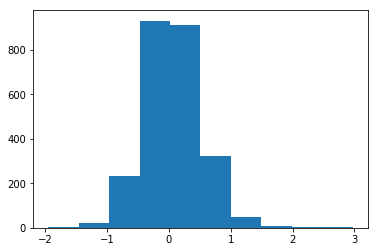

In [98]:
plt.hist(df_train["bias_score_after"])

The decrease is smaller than expected: perhaps more training is necessary?

In [99]:
df_train["original_bias_score"].abs().mean()

0.5631442379398383

In [100]:
df_train["bias_score_after"].abs().mean()

0.35601376955533903

In [101]:
df_val["bias_score_after"] = df_val.progress_apply(compute_bias_score, axis=1)

  0%|          | 0/276 [00:00<?, ?it/s]

  1%|          | 3/276 [00:00<00:10, 27.03it/s]

  2%|▏         | 5/276 [00:00<00:11, 23.32it/s]

  3%|▎         | 7/276 [00:00<00:12, 21.19it/s]

  3%|▎         | 9/276 [00:00<00:13, 19.41it/s]

  4%|▍         | 11/276 [00:00<00:14, 18.72it/s]

  5%|▍         | 13/276 [00:00<00:14, 18.33it/s]

  5%|▌         | 15/276 [00:00<00:14, 18.44it/s]

  6%|▌         | 17/276 [00:00<00:13, 18.51it/s]

  7%|▋         | 19/276 [00:01<00:13, 18.64it/s]

  8%|▊         | 21/276 [00:01<00:13, 18.64it/s]

  8%|▊         | 23/276 [00:01<00:13, 18.61it/s]

  9%|▉         | 25/276 [00:01<00:13, 18.48it/s]

 10%|▉         | 27/276 [00:01<00:13, 18.35it/s]

 11%|█         | 29/276 [00:01<00:13, 18.36it/s]

 11%|█         | 31/276 [00:01<00:13, 18.46it/s]

 12%|█▏        | 33/276 [00:01<00:13, 18.39it/s]

 13%|█▎        | 35/276 [00:01<00:13, 18.26it/s]

 13%|█▎        | 37/276 [00:01<00:12, 18.48it/s]

 14%|█▍        | 39/276 [00:02<00:13, 18.14it/s]

 15%|█▍        | 41/276 [00:02<00:12, 18.26it/s]

 16%|█▌        | 43/276 [00:02<00:12, 18.21it/s]

 16%|█▋        | 45/276 [00:02<00:12, 18.01it/s]

 17%|█▋        | 47/276 [00:02<00:13, 17.13it/s]

 18%|█▊        | 49/276 [00:02<00:13, 17.18it/s]

 18%|█▊        | 51/276 [00:02<00:13, 16.93it/s]

 19%|█▉        | 53/276 [00:02<00:13, 16.77it/s]

 20%|█▉        | 55/276 [00:03<00:12, 17.30it/s]

 21%|██        | 57/276 [00:03<00:12, 17.61it/s]

 21%|██▏       | 59/276 [00:03<00:12, 17.92it/s]

 22%|██▏       | 61/276 [00:03<00:11, 18.22it/s]

 23%|██▎       | 63/276 [00:03<00:11, 18.69it/s]

 24%|██▎       | 65/276 [00:03<00:11, 18.97it/s]

 24%|██▍       | 67/276 [00:03<00:10, 19.27it/s]

 25%|██▌       | 70/276 [00:03<00:10, 19.49it/s]

 26%|██▌       | 72/276 [00:03<00:10, 19.31it/s]

 27%|██▋       | 74/276 [00:04<00:10, 19.11it/s]

 28%|██▊       | 76/276 [00:04<00:10, 18.44it/s]

 28%|██▊       | 78/276 [00:04<00:10, 18.61it/s]

 29%|██▉       | 81/276 [00:04<00:10, 19.14it/s]

 30%|███       | 83/276 [00:04<00:09, 19.34it/s]

 31%|███       | 85/276 [00:04<00:09, 19.53it/s]

 32%|███▏      | 88/276 [00:04<00:09, 19.79it/s]

 33%|███▎      | 91/276 [00:04<00:09, 19.81it/s]

 34%|███▎      | 93/276 [00:04<00:09, 19.74it/s]

 34%|███▍      | 95/276 [00:05<00:09, 19.50it/s]

 35%|███▌      | 97/276 [00:05<00:09, 19.29it/s]

 36%|███▌      | 99/276 [00:05<00:09, 18.83it/s]

 37%|███▋      | 101/276 [00:05<00:09, 18.76it/s]

 37%|███▋      | 103/276 [00:05<00:09, 18.73it/s]

 38%|███▊      | 105/276 [00:05<00:09, 18.80it/s]

 39%|███▉      | 107/276 [00:05<00:08, 18.92it/s]

 39%|███▉      | 109/276 [00:05<00:08, 18.99it/s]

 40%|████      | 111/276 [00:05<00:08, 19.03it/s]

 41%|████      | 113/276 [00:06<00:08, 18.79it/s]

 42%|████▏     | 115/276 [00:06<00:08, 18.58it/s]

 42%|████▏     | 117/276 [00:06<00:08, 18.56it/s]

 43%|████▎     | 119/276 [00:06<00:08, 18.46it/s]

 44%|████▍     | 121/276 [00:06<00:08, 18.27it/s]

 45%|████▍     | 123/276 [00:06<00:08, 18.26it/s]

 45%|████▌     | 125/276 [00:06<00:08, 18.39it/s]

 46%|████▌     | 127/276 [00:06<00:07, 18.77it/s]

 47%|████▋     | 129/276 [00:06<00:07, 18.92it/s]

 47%|████▋     | 131/276 [00:07<00:07, 19.02it/s]

 48%|████▊     | 133/276 [00:07<00:08, 17.84it/s]

 49%|████▉     | 135/276 [00:07<00:07, 18.12it/s]

 50%|█████     | 138/276 [00:07<00:07, 18.71it/s]

 51%|█████     | 140/276 [00:07<00:07, 18.86it/s]

 51%|█████▏    | 142/276 [00:07<00:07, 18.65it/s]

 52%|█████▏    | 144/276 [00:07<00:07, 18.49it/s]

 53%|█████▎    | 146/276 [00:07<00:07, 18.50it/s]

 54%|█████▎    | 148/276 [00:07<00:06, 18.54it/s]

 54%|█████▍    | 150/276 [00:08<00:06, 18.07it/s]

 55%|█████▌    | 152/276 [00:08<00:07, 17.53it/s]

 56%|█████▌    | 154/276 [00:08<00:06, 18.06it/s]

 57%|█████▋    | 156/276 [00:08<00:06, 17.91it/s]

 57%|█████▋    | 158/276 [00:08<00:06, 17.93it/s]

 58%|█████▊    | 160/276 [00:08<00:06, 18.08it/s]

 59%|█████▊    | 162/276 [00:08<00:06, 17.75it/s]

 59%|█████▉    | 164/276 [00:08<00:06, 17.68it/s]

 60%|██████    | 166/276 [00:08<00:06, 17.07it/s]

 61%|██████    | 168/276 [00:09<00:06, 15.72it/s]

 62%|██████▏   | 170/276 [00:09<00:06, 15.34it/s]

 62%|██████▏   | 172/276 [00:09<00:06, 16.19it/s]

 63%|██████▎   | 174/276 [00:09<00:06, 16.89it/s]

 64%|██████▍   | 176/276 [00:09<00:05, 17.31it/s]

 64%|██████▍   | 178/276 [00:09<00:05, 18.04it/s]

 66%|██████▌   | 181/276 [00:09<00:05, 18.50it/s]

 66%|██████▋   | 183/276 [00:09<00:05, 18.46it/s]

 67%|██████▋   | 185/276 [00:10<00:04, 18.70it/s]

 68%|██████▊   | 187/276 [00:10<00:04, 18.83it/s]

 68%|██████▊   | 189/276 [00:10<00:04, 18.79it/s]

 69%|██████▉   | 191/276 [00:10<00:04, 18.81it/s]

 70%|██████▉   | 193/276 [00:10<00:04, 18.75it/s]

 71%|███████   | 195/276 [00:10<00:04, 18.56it/s]

 71%|███████▏  | 197/276 [00:10<00:04, 18.51it/s]

 72%|███████▏  | 199/276 [00:10<00:04, 18.61it/s]

 73%|███████▎  | 201/276 [00:10<00:04, 18.68it/s]

 74%|███████▎  | 203/276 [00:11<00:03, 18.68it/s]

 74%|███████▍  | 205/276 [00:11<00:03, 18.10it/s]

 75%|███████▌  | 207/276 [00:11<00:03, 18.00it/s]

 76%|███████▌  | 209/276 [00:11<00:03, 17.93it/s]

 76%|███████▋  | 211/276 [00:11<00:03, 18.06it/s]

 77%|███████▋  | 213/276 [00:11<00:03, 18.09it/s]

 78%|███████▊  | 215/276 [00:11<00:03, 17.90it/s]

 79%|███████▊  | 217/276 [00:11<00:03, 17.70it/s]

 79%|███████▉  | 219/276 [00:11<00:03, 17.72it/s]

 80%|████████  | 221/276 [00:12<00:03, 17.91it/s]

 81%|████████  | 223/276 [00:12<00:02, 17.70it/s]

 82%|████████▏ | 225/276 [00:12<00:02, 17.53it/s]

 82%|████████▏ | 227/276 [00:12<00:02, 17.26it/s]

 83%|████████▎ | 229/276 [00:12<00:02, 17.02it/s]

 84%|████████▎ | 231/276 [00:12<00:02, 17.12it/s]

 84%|████████▍ | 233/276 [00:12<00:02, 17.21it/s]

 85%|████████▌ | 235/276 [00:12<00:02, 17.09it/s]

 86%|████████▌ | 237/276 [00:12<00:02, 16.82it/s]

 87%|████████▋ | 239/276 [00:13<00:02, 16.78it/s]

 87%|████████▋ | 241/276 [00:13<00:02, 16.92it/s]

 88%|████████▊ | 243/276 [00:13<00:01, 17.36it/s]

 89%|████████▉ | 245/276 [00:13<00:01, 17.51it/s]

 89%|████████▉ | 247/276 [00:13<00:01, 17.46it/s]

 90%|█████████ | 249/276 [00:13<00:01, 17.43it/s]

 91%|█████████ | 251/276 [00:13<00:01, 17.59it/s]

 92%|█████████▏| 253/276 [00:13<00:01, 17.56it/s]

 92%|█████████▏| 255/276 [00:14<00:01, 17.38it/s]

 93%|█████████▎| 257/276 [00:14<00:01, 17.38it/s]

 94%|█████████▍| 259/276 [00:14<00:01, 16.29it/s]

 95%|█████████▍| 261/276 [00:14<00:00, 15.77it/s]

 95%|█████████▌| 263/276 [00:14<00:00, 14.85it/s]

 96%|█████████▌| 265/276 [00:14<00:00, 14.82it/s]

 97%|█████████▋| 267/276 [00:14<00:00, 15.44it/s]

 97%|█████████▋| 269/276 [00:14<00:00, 15.75it/s]

 98%|█████████▊| 271/276 [00:15<00:00, 15.92it/s]

 99%|█████████▉| 273/276 [00:15<00:00, 15.89it/s]

100%|█████████▉| 275/276 [00:15<00:00, 16.39it/s]

100%|██████████| 276/276 [00:15<00:00, 17.92it/s]

In [102]:
df_val["original_bias_score"].abs().mean()

0.6147687844932079

In [103]:
df_val["bias_score_after"].abs().mean()

0.3459238619071202

# Export Weights

As PyTorch state dict

In [104]:
torch.save(masked_lm.state_dict(), MODEL_SAVE_DIR / "state_dict.pth")

TODO: Export as tensorflow checkpoint?